# Defining the APOGEE DR16 halo and N-rich star samples, fitting their densities, and estimating their masses

In this notebook, we make the final definition of the statistical APOGEE DR16 halo star sample. We then fit the density of the entire halo sample. Furthermore, using chemical tagging, we identify N-rich stars in the halo field population. We then test several profiles and fit the N-rich stars with the resulting best fitting profile, whilst for the halo population, we use the functional form from Mackereth & Bovy (2020) and fit the parameters. We then estimate the mass as a function of Galactocentric distance and obtain a ratio of mass in N-rich stars to total stellar halo mass as a function of Galactocentric radius. We also plot the resulting fits and posterior sample distributions, as well as integrate the full density within a ~20 kpc volume to obtain the total stellar halo mass and total mass from N-rich stars

In [1]:
import os
import sys
#ensure that our APOGEE python will read DR16!
os.environ['RESULTS_VERS'] = 'l33'
import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
import apogee.tools.read as apread
from galpy.util import bovy_coords
import mwdust
import tqdm
import gaia_tools.load as gload
import dill as pickle
import multiprocessing
import emcee
import scipy.optimize as op
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import matplotlib
import safe_colours
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


/Users/qpasa/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa



# APOGEE DR16 and the selection function

first, we'll load up the APOGEE DR16 sample, using the distances from Leung & Bovy (2019b):

In [ ]:
#load allStar (main sample w/ Leung & Bovy distances, removing duplicates)
allstar = apread.allStar(main=True, rmdups=True,use_astroNN_distances=True)
print(str(len(allstar))+' stars in total sample.')


/Users/qpasa/opt/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:1336: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")



Then we'll load in the selection function, statistical sample index, and effective selection functions. 

In [3]:
#load selection function/statIndx/effsel if they exist.
if os.path.exists('../sav/apodr16_csf.dat'):
    with open('../sav/apodr16_csf.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    print('No pre-computed selection function found, please refer to selection-function.ipynb')
    
#load statIndx sample and pickle file
if os.path.exists('../sav/statIndx_dr16.dat'):
    with open('../sav/statIndx_dr16.dat', 'rb') as f:
        statIndx = pickle.load(f)
else:
    print('No pre-computed statistical sample found, please refer to selection-function.ipynb')
    
#re-define the distance modulus grid, and the Fe/H, Mg/Fe and eccentricity binning.
#fehbins = np.array([-1.6,-1.4,-1.2,-1.,-0.8])
#afebins = np.array([0.,0.2,0.4])
lowfehbins = np.array([-3.,-1.6])
lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[7.,19.]
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
#load the effective slection a single [Fe/H] selection across the whole range
if os.path.exists('../essf/effsel_grid_inclArea19.dat'):
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_grid_inclArea19.dat', 'rb') as f:
        outarea = pickle.load(f)
else:
    print('No pre-computed effective selection function found, please refer to selection-function.ipynb')
    

100%|██████████| 30/30 [00:03<00:00,  9.99it/s]


Before we move on, need to remove innermost bulge fields, and determine which stars to remove from the sample (i.e. those which are not in fields where we have the selection function):

In [4]:
# Find the spatial coordinates
xyz = bovy_coords.lbd_to_XYZ(allstar[statIndx]['GLON'], allstar[statIndx]['GLAT'], allstar[statIndx]['weighted_dist']/1e3, degree=True)
Rphiz = bovy_coords.XYZ_to_galcencyl(xyz[:,0], xyz[:,1], xyz[:,2], Xsun=8.175, Zsun=0.02)


In [5]:
# mask out to obtain the statistical sample
allstar_f = allstar[statIndx]
print('There are '+str(len(allstar_f))+' stars in the initial APOGEE DR16 statistical sample')

There are 255226 stars in the initial APOGEE DR16 statistical sample


In [6]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
glonglat = np.array([apo.glonGlat(apo._locations[i]) for i in range(len(apo._locations))]).reshape(len(apo._locations),2)
bulgeindx = ((glonglat[:,0] > 350) | (glonglat[:,0] < 10)) & (np.fabs(glonglat[:,1]) < 10)
goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields, bulge fields and one cluster field
# goodindx = goodfields & (apo._locations != 5093) #remove bad fields, bulge fields and one cluster field
goodlocs = apo._locations[goodindx]
# remove data not in the final field list
good_datamask = [allstar_f['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(allstar[statIndx])))]
good_datamask *= allstar_f['weighted_dist']/allstar_f['weighted_dist_error'] > 5.
# setup the grid in Rphiz where the effective selection function is evaluated
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

In [8]:
# make a mask for the final halo sample of RGB stars with good iron and nitrogen abundances
Indx = good_datamask & (allstar_f['N_FE'] > -10) & (allstar_f['FE_H'] > -10) & (allstar_f['LOGG'] > 0.5) & (allstar_f['LOGG']<3.5) & (allstar_f['FE_H']<-1.) & (allstar_f['FE_H']>-3.)& (allstar_f['TEFF']<=4750.)& (allstar_f['TEFF']>=3500.)
print('There are '+str(len(allstar_f[Indx]))+' stars in the initial parent sample')

There are 1660 stars in the initial parent sample


# Remove any known GC stars from the parent sample

In [11]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE 
from astropy.io import fits
# set the path
path = '/Users/qpasa/Desktop/n-rich-halo/sav/'
file = 'GC_sample_statIndx.fits' #merged tables from DR12 and DR14 using APOGEE ID

# read in the merged data table
tb2 = fits.open(path+file)
# select the data
data2 = tb2[1].data #extracts the numeric bit of the data

gc_star_ids = data2.field('col1')
print(str(len(gc_star_ids))+' GC stars')

1014 GC stars


This GC catalogue was determined using the method in Horta et al (2020). See this github repository: https://github.com/DHortaD/apogee-gc

In [13]:
# create a mask with TRUE where the ids of the stars in GCs match the full sample
mask_gcs = np.isin(allstar_f['APOGEE_ID'],gc_star_ids)
print('There are '+str(len(allstar_f[mask_gcs]))+' GC stars in the statistical sample')

There are 1014 GC stars in the statistical sample


In [15]:
haloIndx = (mask_gcs==False) & Indx
print('There are '+str(len(allstar_f[haloIndx]))+' halo field stars in our parent sample')

There are 1455 halo field stars in our parent sample


# Before moving on, let's check the astroNN distances are not affected at large distances

In [16]:
# look at Bovy 2020 and get the corrections for the distances above 6 kpc
# correct the distances for anything above 6 kpc and check to see if they are affected 
def distance_correction_astroNN(distance):
    new = 0.99 + (0.06/np.pi)*((np.pi/2)+np.arctan((distance-4.35)/0.3)) \
    + (0.055/np.pi)*((np.pi/2)+np.arctan((distance-5.5)/0.15))
    return new

In [17]:
good_dist = allstar_f['weighted_dist'][haloIndx]
good_dist = good_dist/1e3

In [18]:
corr_dist = distance_correction_astroNN(good_dist)


Text(0, 0.5, 'N')

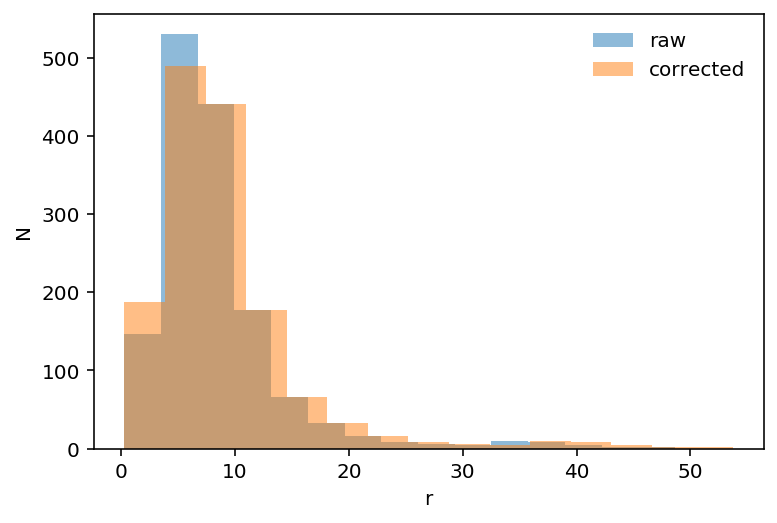

In [19]:
plt.hist(good_dist,15,alpha=0.5,label='raw')
plt.hist(good_dist*corr_dist,15,alpha=0.5,label='corrected')
plt.legend(loc='upper right',frameon=False)
plt.xlabel('r')
plt.ylabel('N')

We find that our distances are not largely affected, and given our distance uncertainty quality cut, decide we are good to proceed

# Now let's study the N/Fe abundances in more detail. Let's look for the raw abundances outputted from ASPCAP. This is to ensure we are not losing any potential N-rich stars which have unreliable N abundances due to them falling of the ASPCAP grid (on the high end)

Let's first look at to see if there are any errors set in the N/Fe flags

[0 0 0 ... 0 0 0]


(array([   0.,    0.,    0.,    0.,    0., 1455.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

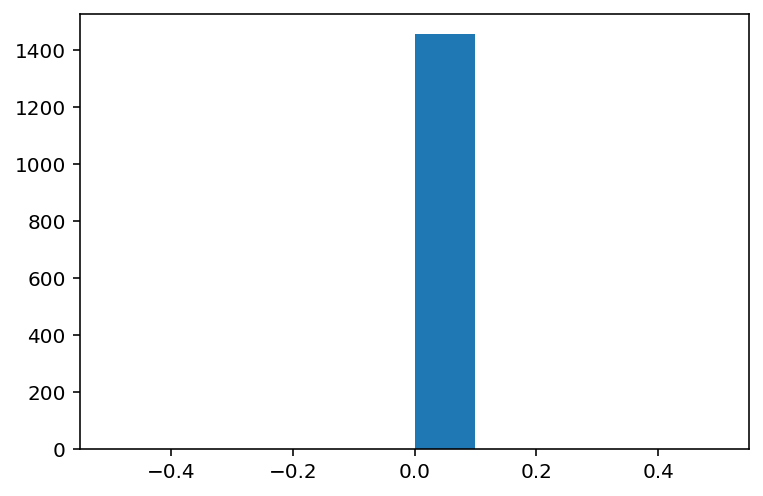

In [20]:
# since the above two arrays don't really match, probs flagged because of this
print(allstar_f['N_FE_FLAG'][haloIndx]&[2**8]) # this is N_M
# find some are, some aren't
plt.hist(allstar_f['N_FE_FLAG'][haloIndx]&[2**12])

In [25]:
mask_badhalo = allstar_f['N_FE_FLAG'][haloIndx]>0


We find this (for obvious reasons) to also be the case for the N-rich star sample

Let's also look at the raw N/M abundances for our N-rich stars

In [23]:
print(allstar_f['X_H'][haloIndx][:,1])
print(allstar_f['X_H'][haloIndx][:,2])

[-1.5981076  -0.96247554 -0.86099154 ... -1.1455635  -1.4203216
 -1.7217615 ]
[-1.2952515 -0.7870715 -0.9381315 ... -1.0306675 -1.1441215 -1.2800915]


In [24]:
print(allstar_f['FELEM'][haloIndx][:,2]) # this is N_M
# raw ASPCAP abundance

[0.28391  0.22589  0.16253  ... 0.026094 0.11684  0.21417 ]


We find our parent samples have reliable abundances, so we set the N_FE_FLAG==0 in our parent sample (to remove any N/Fe = -9999 stars and proceed with the analysis. See the -9999 jupyter notebook for the results for checking the N/Fe = -9999 to see if they were actually N-rich and fell of the ASPCAP grid (due to very high N/Fe abundances). As this isn't the case, we just set the N_FE_FLAG and proceed with the analysis.

# Let's now study the parent sample and determine N-rich stars

In [34]:
# stack the fehs and nfes values, and compute the cov matrix for each feh-nfe pair of values.
# here the errors are uncorrelated, so we just want the variances on the diagonal
data = np.vstack([allstar_f['FE_H'][Indx],allstar_f['N_FE'][Indx]]).T
data_err = np.zeros(data.shape + data.shape[-1:])
diag = np.arange(data.shape[-1])
data_err[:, diag, diag] = np.vstack([allstar_f['FE_H_ERR'][Indx] ** 2, allstar_f['N_FE_ERR'][Indx] ** 2]).T

1660 stars in our halo sample before eliminating GC ids


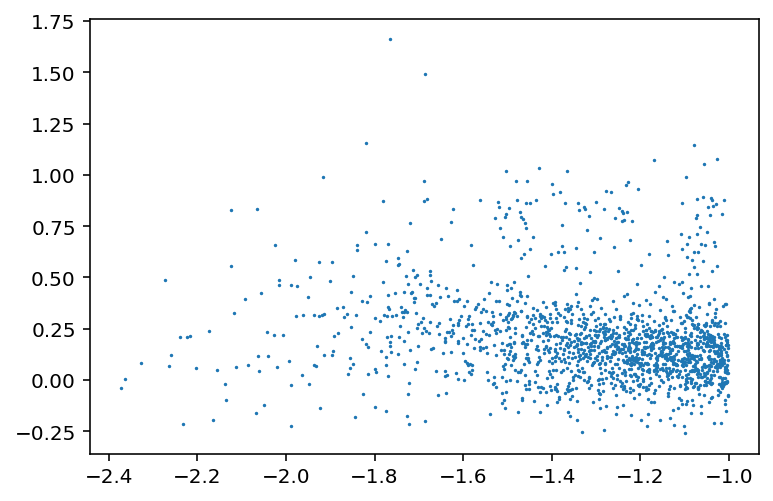

In [35]:
# see what the distribution looks like first
print(str(len(data[:,0]))+' stars in our halo sample before eliminating GC ids')
plt.scatter(data[:,0],data[:,1],s=0.5)

# Perform the extreme deconvolution GMM 

In [36]:
from xdgmm import XDGMM
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
import warnings
# from xdgmm import demo_plots
warnings.filterwarnings('ignore')

# Instantiate an XDGMM model:
xdgmm = XDGMM()
xdgmm.n_components = 3
xdgmm = xdgmm.fit(data, data_err)
print(np.shape(data),np.shape(data_err))

(1660, 2) (1660, 2, 2)


In [37]:
probs = xdgmm.predict_proba(data,data_err)
labels = xdgmm.predict(data,data_err)

again, remove GC stars

In [38]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE 
from astropy.io import fits
# set the path
path = '/Users/qpasa/Desktop/n-rich-halo/sav/'
file = 'GC_sample_statIndx.fits' #merged tables from DR12 and DR14 using APOGEE ID

# read in the merged data table
tb2 = fits.open(path+file)
# select the data
data2 = tb2[1].data #extracts the numeric bit of the data

gc_star_ids = data2.field('col1')
print(str(len(gc_star_ids))+' GC stars')

1014 GC stars


In [39]:
# create a mask with TRUE where the ids of the stars in GCs match the full sample
mask_gcs = np.isin(allstar_f['APOGEE_ID'],gc_star_ids)


255226


In [48]:
nrichIndx = (labels[(mask_gcs[Indx]==False)]==2) & (allstar_f['C_FE'][haloIndx]<0.15)
print(str(len(allstar_f[haloIndx][nrichIndx]))+' N-rich stars in our sample')
test = allstar_f[haloIndx][nrichIndx]
print('The minimum N/Fe value in our N-rich sample is [N/Fe] = '+ str(np.min(test['N_FE'])))

46 N-rich stars in our sample
The minimum N/Fe value in our N-rich sample is [N/Fe] = 0.45760006


Text(0, 0.5, '[N/Fe]')

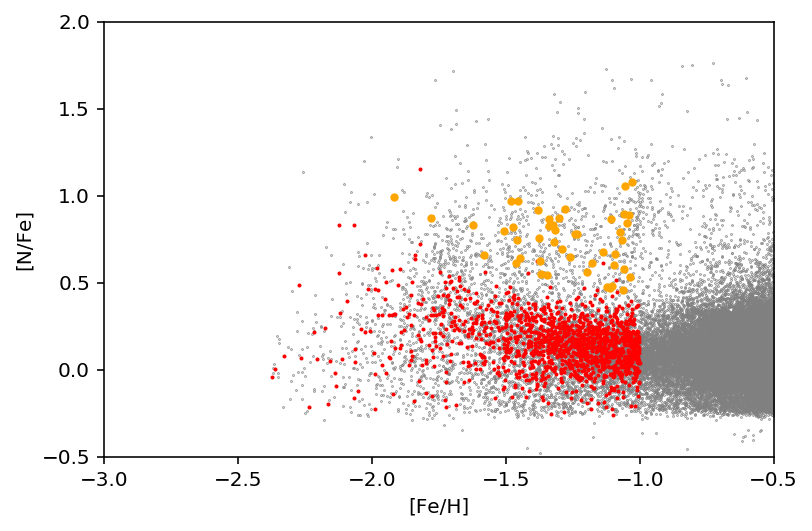

In [49]:
# check the data without and with GC stars removed
plt.scatter(allstar['FE_H'], allstar['N_FE'], s=0.1,c='gray')
plt.scatter(allstar_f['FE_H'][haloIndx], allstar_f['N_FE'][haloIndx], s=1,c='red')
plt.scatter(allstar_f['FE_H'][haloIndx][nrichIndx], allstar_f['N_FE'][haloIndx][nrichIndx], s=10,c='orange')

plt.xlim(-3.,-0.5)
plt.ylim(-0.5,2.)
plt.xlabel('[Fe/H]')
plt.ylabel('[N/Fe]')

Text(0, 0.5, 'logg')

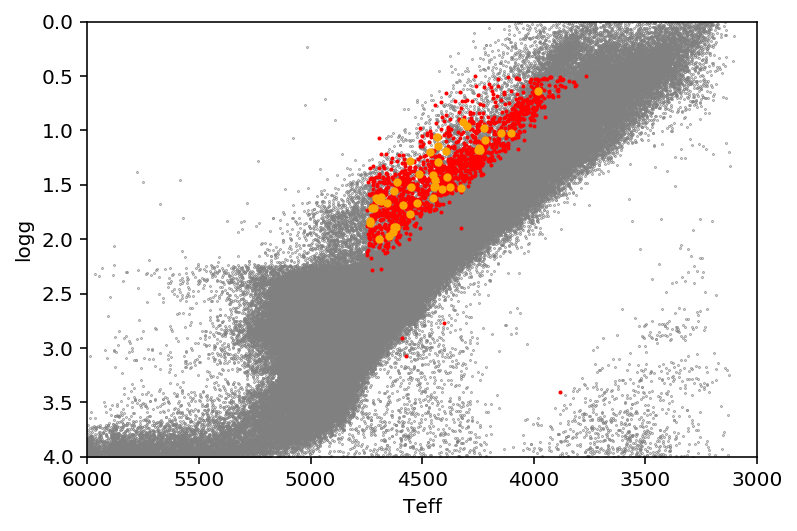

In [50]:
# check the data without and with GC stars removed
plt.scatter(allstar['TEFF'], allstar['LOGG'], s=0.1,c='gray')
plt.scatter(allstar_f['TEFF'][haloIndx], allstar_f['LOGG'][haloIndx], s=1,c='red')
plt.scatter(allstar_f['TEFF'][haloIndx][nrichIndx], allstar_f['LOGG'][haloIndx][nrichIndx], s=10,c='orange')

plt.xlim(6000,3000)
plt.ylim(4,0)
plt.xlabel('Teff')
plt.ylabel('logg')

NOTES:

here allstar_f is the statistical sample

haloIndx is the mask applied to the halo sample, where GC stars are removed and the following cuts are applied:
        good_datamask & (allstar_f['N_FE'] > -10) & (allstar_f['FE_H'] > -10) & \
            (allstar_f['LOGG']<3.5) & (allstar_f['LOGG']>0.5) & (allstar_f['TEFF']<=4750.) & (allstar_f['FE_H']<-1.)
                            & (allstar_f['FE_H']>-3.)
                            
nrichIndx is the mask applied to the nrich sample, with same length as the haloIndx mask (with GC stars removed),
given by the following cuts:
            (labels[(mask_gcs[Indx]==False)]==0) & (allstar_f['C_FE'][haloIndx]<0.15)

where the labels cut is derived from the GMM performed on the halo sample to determine N-Rich stars accounting for
uncertainties in the N/Fe and Fe/H values


# See where the halo and N-rich samples are located in space

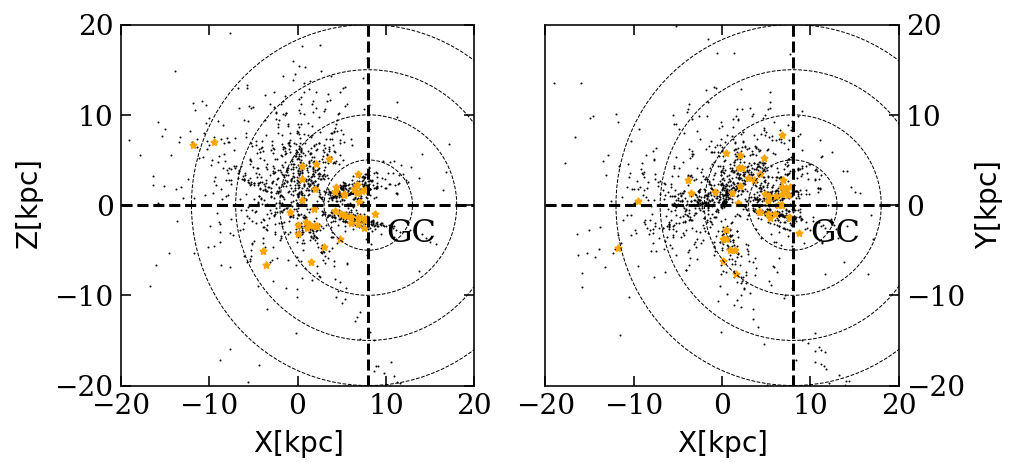

In [52]:
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = bovy_coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8., Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(allstar_f[haloIndx])
oXYZ, oRphiz = allstar_to_coords(allstar_f[haloIndx][nrichIndx])



theta = np.linspace(0, 2*np.pi, 100)
r = np.sqrt(1.0)
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(24,8))
fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
ax[0].scatter(XYZ[:,0],XYZ[:,2], c='Black', s=1, lw=0., zorder=-1, rasterized=True)
ax[0].scatter(oXYZ[:,0],oXYZ[:,2], c='Orange', s=10., marker='*')
ax[0].axvline(8., c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-20,20)
ax[0].set_xlim(-20,20)
# ax[0].legend(loc='lower left',frameon=False)
ax[1].scatter(XYZ[:,0],XYZ[:,1], c='Black', s=1, lw=0., zorder=-1, rasterized=True)
ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
s = ax[1].scatter(oXYZ[:,0], oXYZ[:,1], c='Orange', s=10., marker='*')

ax[1].axvline(8., c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$')
ax[0].text(10,-4,r'GC', fontsize=16)
ax[1].text(10,-4,r'GC', fontsize=16)
ax[0].tick_params(direction='in', right=True,top=True,length=5)
ax[1].tick_params(direction='in', right=True,top=True,length=5)

# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')


# And check their distribution as a function of radius

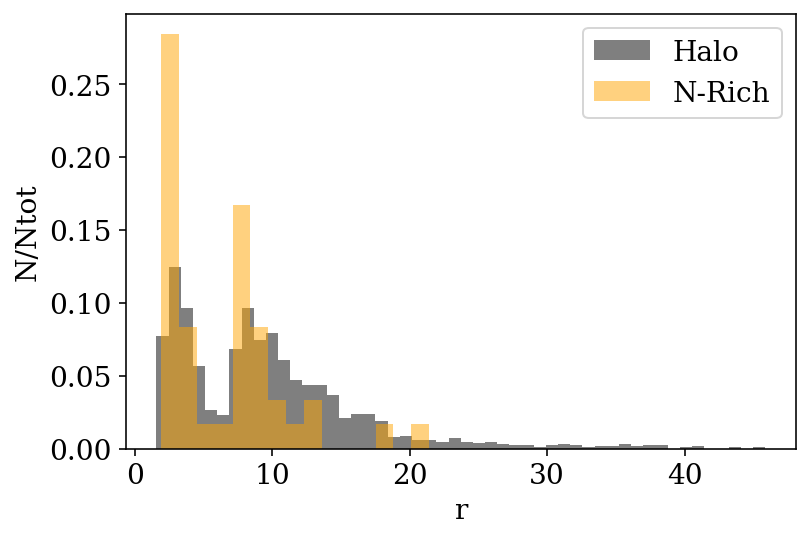

In [53]:
rad = np.sqrt(Rphiz[:,0]**2+Rphiz[:,2]**2)
rad_rich = np.sqrt(oRphiz[:,0]**2+oRphiz[:,2]**2)
plt.hist(rad,50,alpha=0.5,label='Halo',color='k',density=True)
plt.hist(rad_rich,15,alpha=0.5,label='N-Rich',color='orange',density=True) #If Density= True, the first element of the return tuple will be the counts normalized to form a probability density, i.e., the area (or integral) under the histogram will sum to 1. This is achieved by dividing the count by the number of observations times the bin width and not dividing by the total number of observations. If stacked is also True, the sum of the histograms is normalized to 1.
plt.xlabel('r',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel('N/Ntot')
plt.legend(fontsize=14)

# For N-rich stars -3 < [Fe/H] < -1...

46 N-Rich stars in our sample
1409 Halo stars in our sample


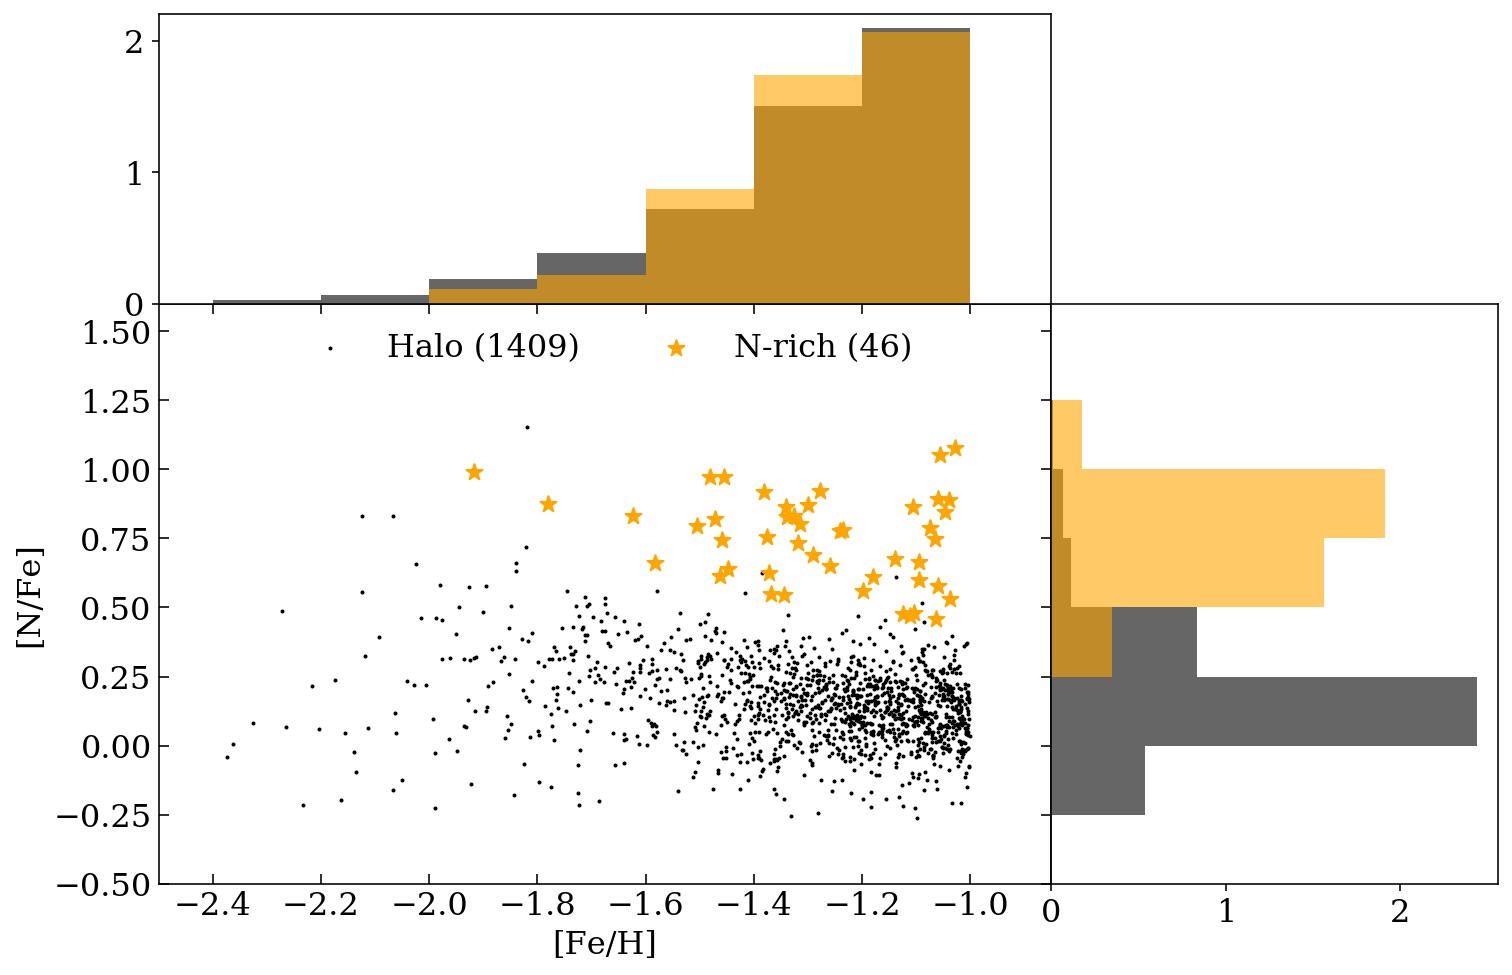

In [57]:
import matplotlib.gridspec as grid

fig = plt.figure(constrained_layout=True,figsize=(12,8))
plt.rc('font',family='serif',size=14)
gs = grid.GridSpec(3,3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

ax_main.scatter(allstar_f['FE_H'][haloIndx],allstar_f['N_FE'][haloIndx],c='k',s=1,label='Halo (1409)',rasterized=True)
ax_main.scatter(allstar_f['FE_H'][haloIndx][nrichIndx],allstar_f['N_FE'][haloIndx][nrichIndx],c='orange',marker='*',s=70,label='N-rich (46)',rasterized=True)
ax_main.set_xlim(-2.5,-0.85)
ax_main.set_ylim(-0.5,1.6)
ax_main.set_xlabel('[Fe/H]',fontsize=16)
ax_main.set_ylabel('[N/Fe]',fontsize=16)
ax_main.tick_params(labelsize=16,direction='in', right=True,top=True,length=5)
ax_main.legend(loc='upper center',fontsize=16,ncol=2,frameon=False)

ax_xDist.hist(allstar_f['FE_H'][haloIndx],bins=[-2.4,-2.2,-2.,-1.8,-1.6,-1.4,-1.2,-1.],\
              align='mid',color='k',alpha=0.6,density=True, label=str(len(allstar_f['FE_H'][haloIndx]))+ ' Halo')
ax_xDist.hist(allstar_f['FE_H'][haloIndx][nrichIndx],bins=[-2.4,-2.2,-2.,-1.8,-1.6,-1.4,-1.2,-1.],\
              align='mid',color='orange',alpha=0.6,density=True,label=str(len(allstar_f['FE_H'][haloIndx][nrichIndx]))+' N-rich')
ax_xDist.tick_params(labelbottom=False,bottom=False,labelsize=16)
# ax_xDist.legend(loc='upper left',fontsize=16)
# ax_xDist.set_ylabel(r'N/Ntotal * $\Delta$[Fe/H]', fontsize=16)

ax_yDist.hist(allstar_f['N_FE'][haloIndx],bins=[-0.5,-0.25,0.,0.25,0.5,0.75,1.,1.25,1.5],align='mid',color='k',alpha=0.6,orientation='horizontal',density=True)
ax_yDist.hist(allstar_f['N_FE'][haloIndx][nrichIndx],bins=[-0.5,-0.25,0.,0.25,0.5,0.75,1.,1.25,1.5],align='mid',color='orange',alpha=0.6,orientation='horizontal',density=True)
ax_yDist.tick_params(labelleft=False,left=False,labelsize=16)
# ax_yDist.set_xlabel(r'N/Ntotal * $\Delta$[N/Fe]', fontsize=16)

gs.update(wspace=0.,hspace=0.)

plt.savefig('../plots/nfe_fehs.pdf', format='pdf', dpi=400, bbox_inches='tight')


print(str(len(allstar_f['FE_H'][haloIndx][nrichIndx])) +' N-Rich stars in our sample')
print(str(len(allstar_f['FE_H'][haloIndx][~nrichIndx])) +' Halo stars in our sample')



In [54]:
# PERFORM A KS TEST ON THE MDFS OF N-RICH AND HALO SAMPLES

from scipy import stats

D, p_value = stats.ks_2samp(allstar_f['FE_H'][haloIndx], allstar_f['FE_H'][haloIndx][nrichIndx])

print(D,p_value)

0.09955177050649934 0.7469038931445819


# Now that we have found the N-rich stars, compare the light element abundance correlations with a sample of GC stars from Horta et al (2020)

In [116]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE from Horta et al 2020
from astropy.io import fits
# set the path
path = '/Users/qpasa/Desktop/Master/data/'
file = 'GCs_DR16' #merged tables from DR12 and DR14 using APOGEE ID

# read in the merged data table
tb3 = fits.open(path+file)
# select the data
data3 = tb3[1].data #extracts the numeric bit of the data

name_gc = data3.field('gc_name')
c_gc = data3.field('C_FE')
n_gc = data3.field('N_FE')
al_gc = data3.field('AL_FE')
mg_gc = data3.field('MG_FE')

print(str(len(name_gc))+' GC stars')

3090 GC stars


46 N-Rich stars in our sample


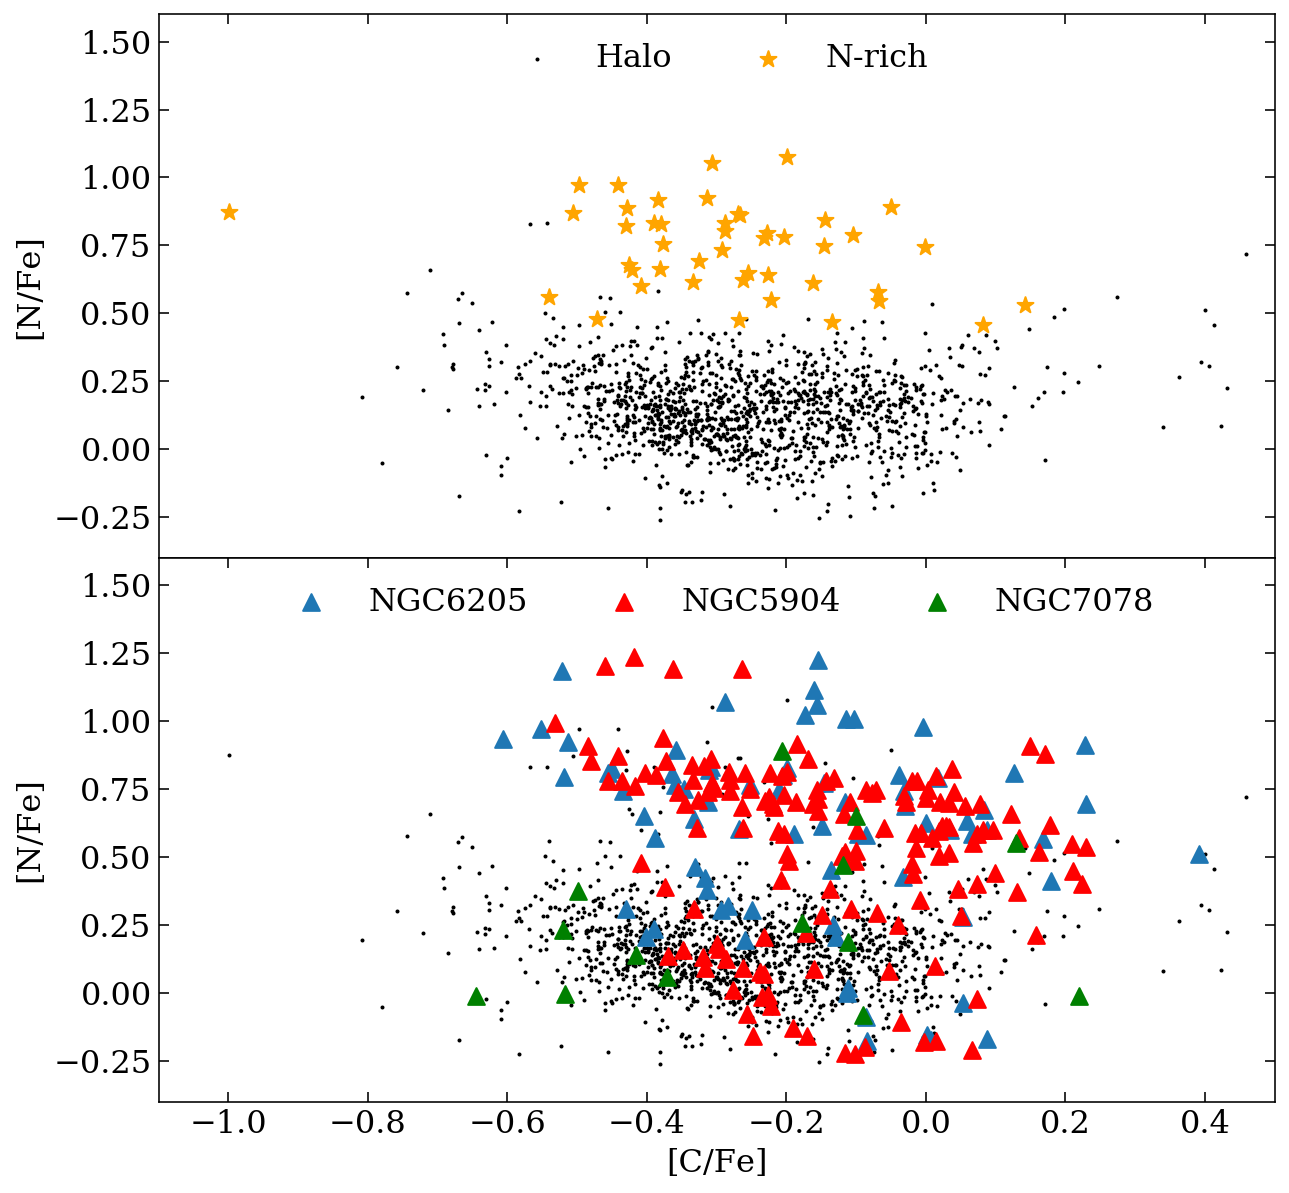

In [58]:
fig = plt.figure(constrained_layout=True,figsize=(10,10))
plt.rc('font',family='serif',size=14)
gs = grid.GridSpec(2,1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.scatter(allstar_f['C_FE'][haloIndx],allstar_f['N_FE'][haloIndx],c='k',s=1,label='Halo')
ax.scatter(allstar_f['C_FE'][haloIndx][nrichIndx],allstar_f['N_FE'][haloIndx][nrichIndx],c='orange',marker='*',s=70,label='N-rich')
ax.set_xlim(-1.1,.5)
ax.set_ylim(-0.4,1.6)
ax.set_xlabel('[C/Fe]',fontsize=16)
ax.set_ylabel('[N/Fe]',fontsize=16)
ax.tick_params(labelsize=16,labelbottom=False,bottom=False)
ax.legend(ncol=2,fontsize=16,loc='upper center',frameon=False)
ax.tick_params(direction='in', right=True,top=True,length=5)

ax2.scatter(allstar_f['C_FE'][haloIndx],allstar_f['N_FE'][haloIndx],c='k',s=1)
ax2.scatter(c_gc[name_gc=='NGC6205'],n_gc[name_gc=='NGC6205'],marker='^',s=70,label='NGC6205')
# ax2.scatter(c_gc[name_gc=='NGC6229'],n_gc[name_gc=='NGC6229'],marker='^',s=70,label='NGC6229')
ax2.scatter(c_gc[name_gc=='NGC5904'],n_gc[name_gc=='NGC5904'],marker='^',s=70,label='NGC5904',c='r')
ax2.scatter(c_gc[name_gc=='NGC7078'],n_gc[name_gc=='NGC7078'],marker='^',s=70,label='NGC7078',c='g')
# ax2.scatter(c_gc[name_gc=='NGC6656'],n_gc[name_gc=='NGC6656'],marker='^',s=70,label='NGC6656')
ax2.set_xlim(-1.1,.5)
ax2.set_ylim(-0.4,1.6)
ax2.set_xlabel('[C/Fe]',fontsize=16)
ax2.set_ylabel('[N/Fe]',fontsize=16)
ax2.tick_params(labelsize=16)
ax2.legend(ncol=4,fontsize=16,loc='upper center',frameon=False)
ax2.tick_params(direction='in', right=True,top=True,length=5)


gs.update(wspace=0.,hspace=0.)

# plt.savefig('../plots/cfes.pdf', format='pdf', dpi=400, bbox_inches='tight')



print(str(len(allstar_f['FE_H'][haloIndx][nrichIndx])) +' N-Rich stars in our sample')



46 N-Rich stars in our sample


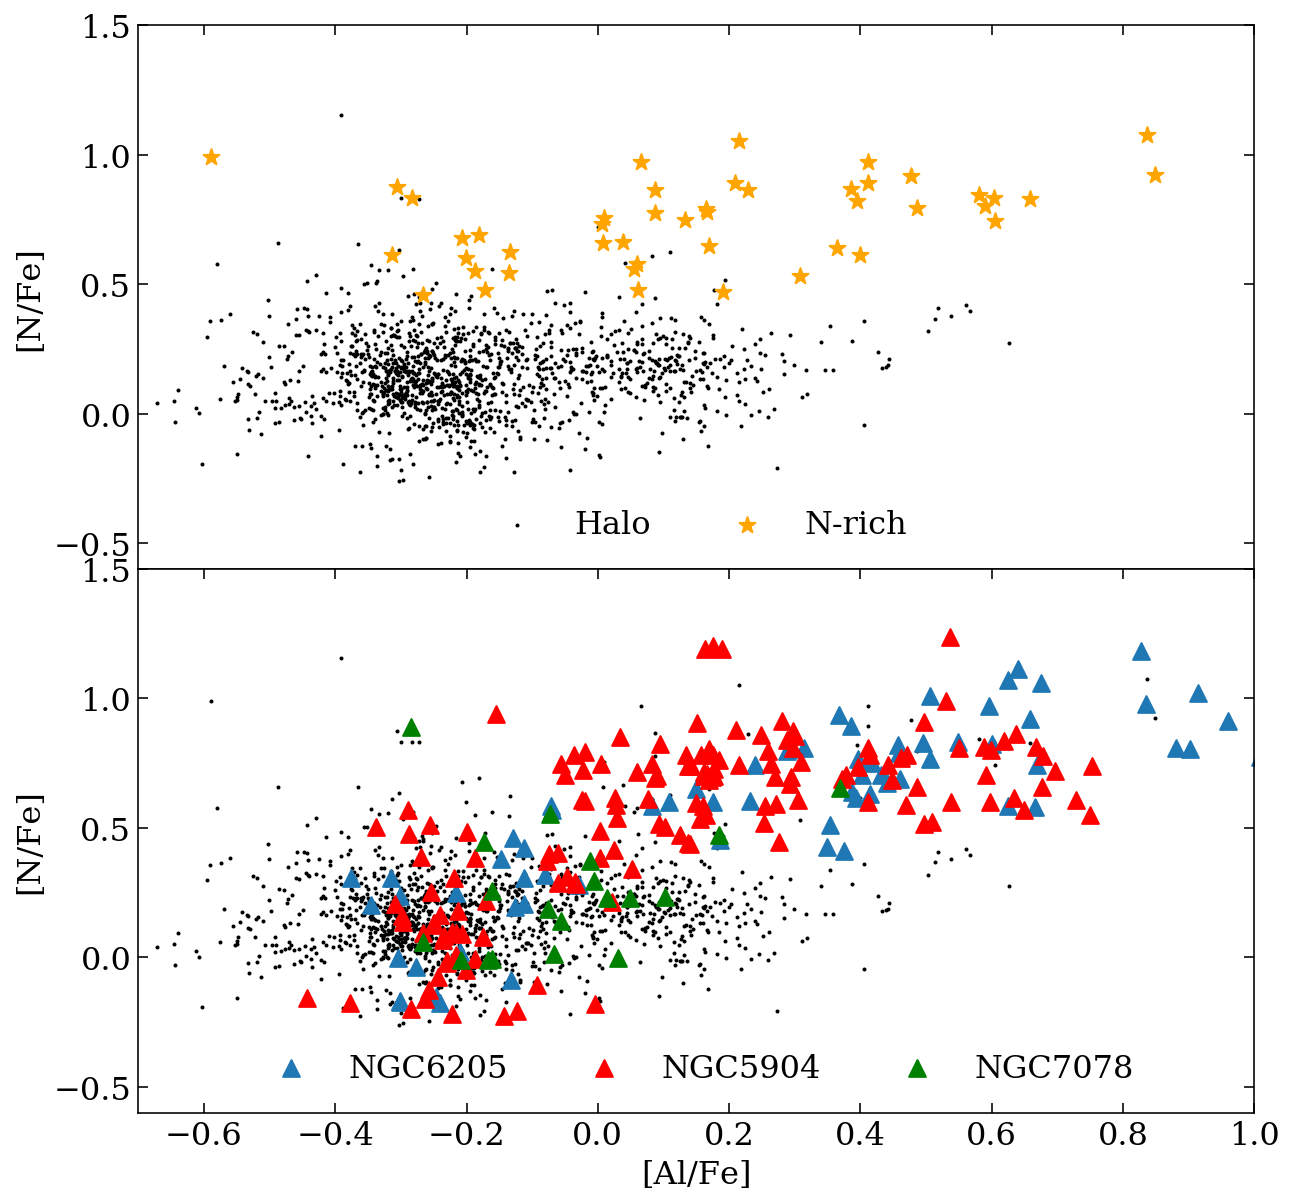

In [60]:
fig = plt.figure(constrained_layout=True,figsize=(10,10))
plt.rc('font',family='serif',size=14)
gs = grid.GridSpec(2,1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.scatter(allstar_f['AL_FE'][haloIndx],allstar_f['N_FE'][haloIndx],c='k',s=1,label='Halo')
ax.scatter(allstar_f['AL_FE'][haloIndx][nrichIndx],allstar_f['N_FE'][haloIndx][nrichIndx],c='orange',marker='*',s=70,label='N-rich')
ax.set_xlim(-0.7,1.)
ax.set_ylim(-0.6,1.5)
# ax.set_xlabel('[Al/Fe]',fontsize=16)
ax.set_ylabel('[N/Fe]',fontsize=16)
ax.tick_params(labelsize=16,labelbottom=False,bottom=False)
ax.legend(ncol=2,fontsize=16,loc='lower center',frameon=False)
ax.tick_params(direction='in', right=True,top=True,length=5)

ax2.scatter(allstar_f['AL_FE'][haloIndx],allstar_f['N_FE'][haloIndx],c='k',s=1)
ax2.scatter(al_gc[name_gc=='NGC6205'],n_gc[name_gc=='NGC6205'],marker='^',s=70,label='NGC6205')
# ax2.scatter(al_gc[name_gc=='NGC6229'],n_gc[name_gc=='NGC6229'],marker='^',s=70,label='NGC6229')
ax2.scatter(al_gc[name_gc=='NGC5904'],n_gc[name_gc=='NGC5904'],marker='^',s=70,label='NGC5904',c='r')
ax2.scatter(al_gc[name_gc=='NGC7078'],n_gc[name_gc=='NGC7078'],marker='^',s=70,label='NGC7078',c='g')
# ax2.scatter(al_gc[name_gc=='NGC6656'],n_gc[name_gc=='NGC6656'],marker='^',s=70,label='NGC6656')
ax2.set_xlim(-0.7,1.)
ax2.set_ylim(-0.6,1.5)
ax2.set_xlabel('[Al/Fe]',fontsize=16)
ax2.set_ylabel('[N/Fe]',fontsize=16)
ax2.tick_params(labelsize=16)
ax2.legend(ncol=4,fontsize=16,loc='lower center',frameon=False)
ax2.tick_params(direction='in', right=True,top=True,length=5)

gs.update(wspace=0.,hspace=0.)

# plt.savefig('../plots/alfes.pdf', format='pdf', dpi=400, bbox_inches='tight')



print(str(len(allstar_f['FE_H'][haloIndx][nrichIndx])) +' N-Rich stars in our sample')





46 N-Rich stars in our sample


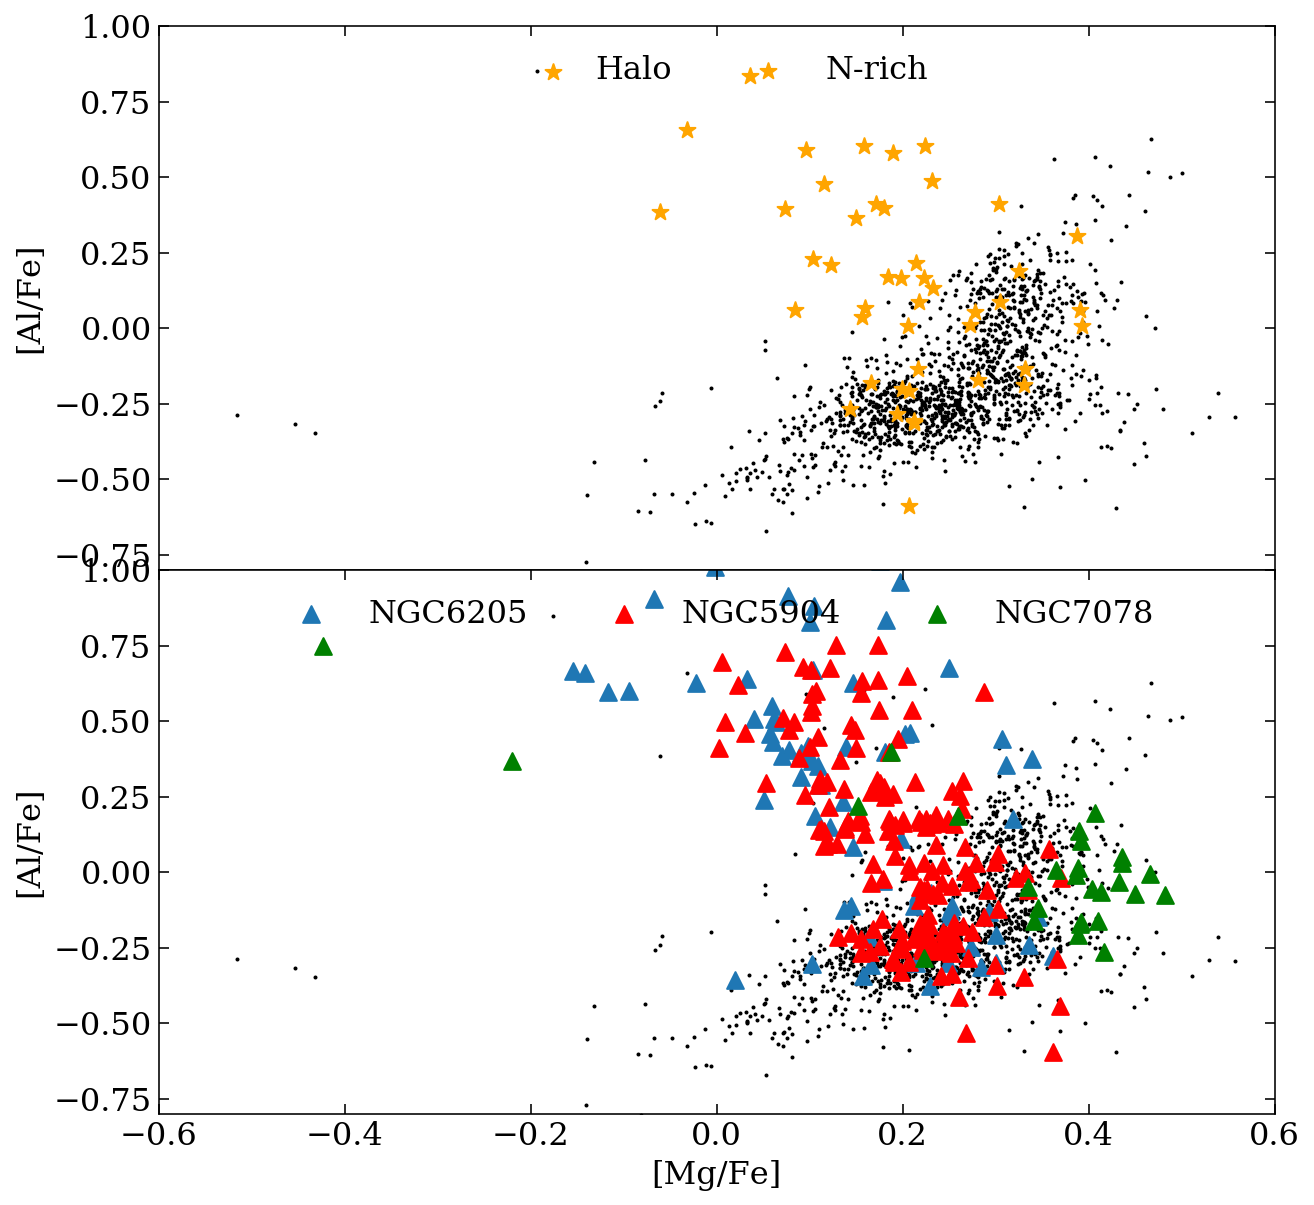

In [119]:
fig = plt.figure(constrained_layout=True,figsize=(10,10))
plt.rc('font',family='serif',size=14)
gs = grid.GridSpec(2,1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.scatter(allstar_f['MG_FE'][haloIndx],allstar_f['AL_FE'][haloIndx],c='k',s=1,label='Halo')
ax.scatter(allstar_f['MG_FE'][haloIndx][nrichIndx],allstar_f['AL_FE'][haloIndx][nrichIndx],c='orange',marker='*',s=70,label='N-rich')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.8,1.)
ax.set_xlabel('[Mg/Fe]',fontsize=16)
ax.set_ylabel('[Al/Fe]',fontsize=16)
ax.tick_params(labelsize=16,labelbottom=False,bottom=False)
ax.legend(ncol=2,fontsize=16,loc='upper center',frameon=False)
ax.tick_params(direction='in', right=True,top=True,length=5)

ax2.scatter(allstar_f['MG_FE'][haloIndx],allstar_f['AL_FE'][haloIndx],c='k',s=1)
ax2.scatter(mg_gc[name_gc=='NGC6205'],al_gc[name_gc=='NGC6205'],marker='^',s=70,label='NGC6205')
# ax2.scatter(mg_gc[name_gc=='NGC6229'],al_gc[name_gc=='NGC6229'],marker='^',s=70,label='NGC6229')
ax2.scatter(mg_gc[name_gc=='NGC5904'],al_gc[name_gc=='NGC5904'],marker='^',s=70,label='NGC5904',c='r')
ax2.scatter(mg_gc[name_gc=='NGC7078'],al_gc[name_gc=='NGC7078'],marker='^',s=70,label='NGC7078',c='g')
# ax2.scatter(mg_gc[name_gc=='NGC6656'],al_gc[name_gc=='NGC6656'],marker='^',s=70,label='NGC6656')
ax2.set_xlim(-0.6,.6)
ax2.set_ylim(-0.8,1.)
ax2.set_xlabel('[Mg/Fe]',fontsize=16)
ax2.set_ylabel('[Al/Fe]',fontsize=16)
ax2.tick_params(labelsize=16)
ax2.legend(ncol=4,fontsize=16,loc='upper center',frameon=False)
ax2.tick_params(direction='in', right=True,top=True,length=5)


gs.update(wspace=0.,hspace=0.)

# plt.savefig('../plots/cfes.pdf', format='pdf', dpi=400, bbox_inches='tight')



print(str(len(allstar_f['FE_H'][haloIndx][nrichIndx])) +' N-Rich stars in our sample')




# Let's now move onto modelling the density of our samples

In [61]:
#these functions are necessary to do the fits to the APOGEE giants. They could be in with the utils, but for simplicity, I just put them here!
from scipy import integrate

#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

def calc_bic_loglike(mask, params, fehrange=[-1.6,-1.], effsel=outarea, model = densprofiles.spherical):
    loglike = utils.loglike(params,model, effsel[goodindx]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
    print((sum(mask)))
    bic = sum(params)*np.log(sum(mask))-2*loglike
    return bic, loglike
    
def fit_bin_mask(mask, fehrange=[-1.6,-1.], effsel=outarea, model=densprofiles.spherical, just_MLE=True, just_MCMC=False, mass=False, init= [2.], ncut=40, analytic=False, inttype='spherical'):
    '''
    Fits the stars defined by a mask to the APOGEE low metallicity sample
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    fehrange - the range in Fe/H spanned by the sample defined by mask
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    just_MLE - do the Maximum Likelihood and return opt
    just_MCMC - do the MCMC
    mass - also compute the total mass
    init - initial input parameters for the density model
    ncut - number of samples to cut from each MCMC chain
    analytic - compute the mass integral analytically (only works for spherical density models)
    inttype - the coordinate scheme for the integration grid for mass computation
    OUTPUT:
    opt - opt from op.minimize
    samples - MCMC samples
    masses - MC samples of mass
    facs - the normalisation factor corresponding to each mass sample
    '''
    #needs goodindx defined above. 'mask' must be same length as gaia2_matches[omask].
    print(sum(mask))
    if not just_MCMC:
        # do MLE. 
        mloglike = lambda x: utils.mloglike(x,model, effsel[goodindx]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
        print(mloglike)
        opt = op.fmin(lambda x: utils.mloglike(x,model, effsel[goodindx]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask]), init, full_output=True)
        print(opt[0])
        if just_MLE:
            return opt
    # do MCMC initialised from best result from MLE or from init params given
    ndim, nwalkers = len(init), 100
    if just_MCMC:
        pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    else:
        pos = [opt[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    nit = 200
    threads = 4
    #only effsel for good fields
    effsel_in = effsel[goodindx]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
    #re-build Rphiz grid
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx]
    #set up sampler and do the sampling.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0][mask], Rphiz[:,1][mask], Rphiz[:,2][mask]), 
                                        threads=threads)
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    #cut ncut samples from each chain
    samples = sampler.chain[:, ncut:, :].reshape((-1, ndim))
    if not mass:
        if just_MCMC:
            return samples
        else:
            return opt, samples
    isofactors = np.zeros(len(effsel[goodindx]))
    for i in tqdm.tqdm_notebook(range(len(isofactors))):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 3500.) & (10**(isorec['logTe']) < 4750.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx][i], maxjk=jkmaxs[goodindx][i])
        isofactors[i] = avmass/massratio #fraction of stellar mass in giants
    #set up grid for integration
        rthetaphigrid = np.mgrid[1.5:20:150j,0:np.pi:150j,0:2*np.pi:150j]
        dr = (20-1.5)/149
        dtheta = (np.pi-0.)/149
        dphi = (2*np.pi-0.)/149
        shape = np.shape(rthetaphigrid.T)
        rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
        deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
        x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
        y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
        z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
        xyzgrid = np.dstack([x,y,z])[0]
        rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if inttype == 'cartesian':
        xyzgrid = np.mgrid[-50.:50.:150j,-50.:50.:150j,-50.:50.:150j]
        delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
        deltafactor = delta**3
        shape = np.shape(xyzgrid.T)
        xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
        rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk or model is densprofiles.triaxial_broken_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
        masses = np.zeros((400,3))
    else:
        masses = np.zeros(400)
    facs = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 400, replace=False)]), total=400):
        rate = model(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params)*effsel[goodindx]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate.T/isofactors) #conversion factor between RGB number counts and total stellar mass
        norm = sum(mask)/sumrate
        fac = norm*(180./np.pi)**2  #conversion factor between RGB number counts and total stellar mass accounted for density normalisation
        if analytic:
            #only for spherical power law!
            rsun = np.sqrt(8.**2+0.02**2)
            min_r = 1.5
            max_r = 20.
            alpha = params[0]
            integral = 4*np.pi*((rsun**alpha*max_r**(3-alpha))/(3-alpha)-(rsun**alpha*min_r**(3-alpha))/(3-alpha))
            masses[ii] = integral*fac
        else:
            if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk or model is densprofiles.triaxial_broken_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
                denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
                halodens = denstxyz[0]*fac
                diskdens = denstxyz[1]*fac
                fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
                masses[ii] = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)
            else:
                densfunc = lambda r,phi,z: r*model(r,phi,z,params=params)
                integral = integrate.nquad(densfunc, [[1.5,20.],[0.,2*np.pi],[-30.,30.]])
                masses[ii] = integral[0]*fac
        facs[ii] = fac
    if just_MCMC:
        return samples, masses, facs
    return opt, samples, masses, facs

def normalisation_from_fixed_profile(mask, effsel, model, params, fehrange=[-3.,-1.], fixnorm=None):
    '''
    computes the normalisation or mass from the APOGEE star counts for a fixed profile
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    params - parameters of the input density model (fixed)
    fehrange - the range in Fe/H spanned by the sample defined by mask
    fixnorm - fix normalisation to one (supplied) value (instead of using APOGEE star counts)
    OUTPUT:
    fac - the normalisation factor (returns fixnorm if set)
    mass - the mass for the input parameters 
    norm - normalisation factor
    '''
    isofactors = np.zeros(len(effsel[goodindx]))
    for i in range(len(isofactors)):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 3500.)& (10**(isorec['logTe']) < 4750.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx][i])
        isofactors[i] = avmass/massratio
    rthetaphigrid = np.mgrid[2.:70.:200j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (70.-2.)/199
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    shape = np.shape(rthetaphigrid.T)
    rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
    deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
    x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
    y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
    z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
    xyzgrid = np.dstack([x,y,z])[0]
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rate = model(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params)*effsel[goodindx]*ds**3*(distmods[1]-distmods[0])
    sumrate = np.sum(rate.T/isofactors)
    norm = sum(mask)/sumrate
    fac = norm*(180./np.pi)**2
    if fixnorm is not None:
        fac = fixnorm*(1e3)**3
    if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
        halodens = denstxyz[0]*fac
        diskdens = denstxyz[1]*fac
        fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)
    else:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass =  np.sum(denstxyz*deltafactor)
    return fac, mass, norm


# Fitting the entire Halo and N-Rich samples

First, we fit the triaxial single power law with exponential cut-off to the entire sample of stars between $-3 < \mathrm{[Fe/H]} < -1$. We also fit a simple spherical power law to demonstrate the better quality of the fit afforded by the more complex profile.

First up, lets make a mask for this sample, and look at its extent in $R$ and $z$: 

number of stars in full Fe/H range: 1409


Text(0, 0.5, '$z\\ \\mathrm{[kpc]}$')

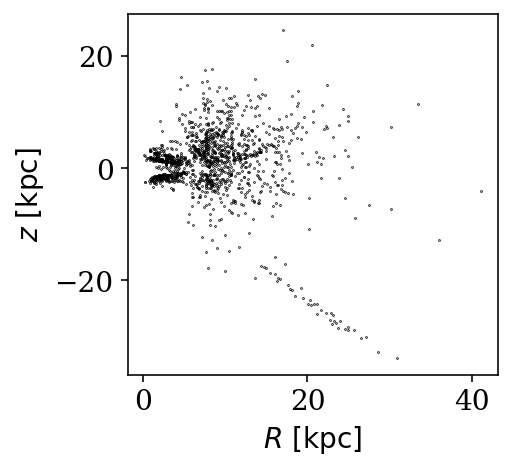

In [62]:
print('number of stars in full Fe/H range: '+str(sum(~nrichIndx))+'')
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
plt.scatter(Rphiz[:,0][~nrichIndx], Rphiz[:,2][~nrichIndx], s=0.1,c='k')
plt.xlabel(r'$R\ \mathrm{[kpc]}$')
plt.ylabel(r'$z\ \mathrm{[kpc]}$')

Now, lets fit this sample for the two models using `fit_bin_mask` as defined above:

# Now let's move onto fitting the halo sample. We will fit the Triaxial+Rotation+Disc+Cut-off from Mackereth & Bovy (2020)

In [64]:
mask = ~nrichIndx
# triaxial+rot+cutoff+disc
haloopt, halosamples, halomasses, halofacs = fit_bin_mask(mask, fehrange=[-3.,-1.], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.,0.1,0.8,0.5,0.1,0.1,0.1,0.01], ncut=100, analytic=False)


1409
<function fit_bin_mask.<locals>.<lambda> at 0x35addbe60>
Optimization terminated successfully.
         Current function value: 18009.958293
         Iterations: 562
         Function evaluations: 897
[3.52819974e+00 1.00000042e-02 7.96813464e-01 4.54088809e-01
 2.78644931e-01 2.50548094e-03 1.93612985e-01 1.13303408e-02]


In [ ]:
# get the halo normalisation and total mass for the best fit profile
percen1 = np.percentile(halofacs*1e-9,[16,50,84])
percen2 = np.percentile(halomasses[:,0],[16,50,84])
print(percen1)
print(percen2)
# and the disc mass
percen3 = np.percentile(halomasses[:,1],[16,50,84])
print(percen3)

In [65]:
# spherical
haloopt2, halosamples2, halomasses2, halofacs2 = fit_bin_mask(mask, fehrange=[-3.,-1.], effsel=outarea, model=densprofiles.spherical, just_MLE=False, just_MCMC=False, mass=True, init= [2.], ncut=100, analytic=True)


1409
<function fit_bin_mask.<locals>.<lambda> at 0x35addbe60>
Optimization terminated successfully.
         Current function value: 18362.267775
         Iterations: 16
         Function evaluations: 32
[3.21425781]


# Let's see what the posterior distributions of the samples look like

1409



1409



1409


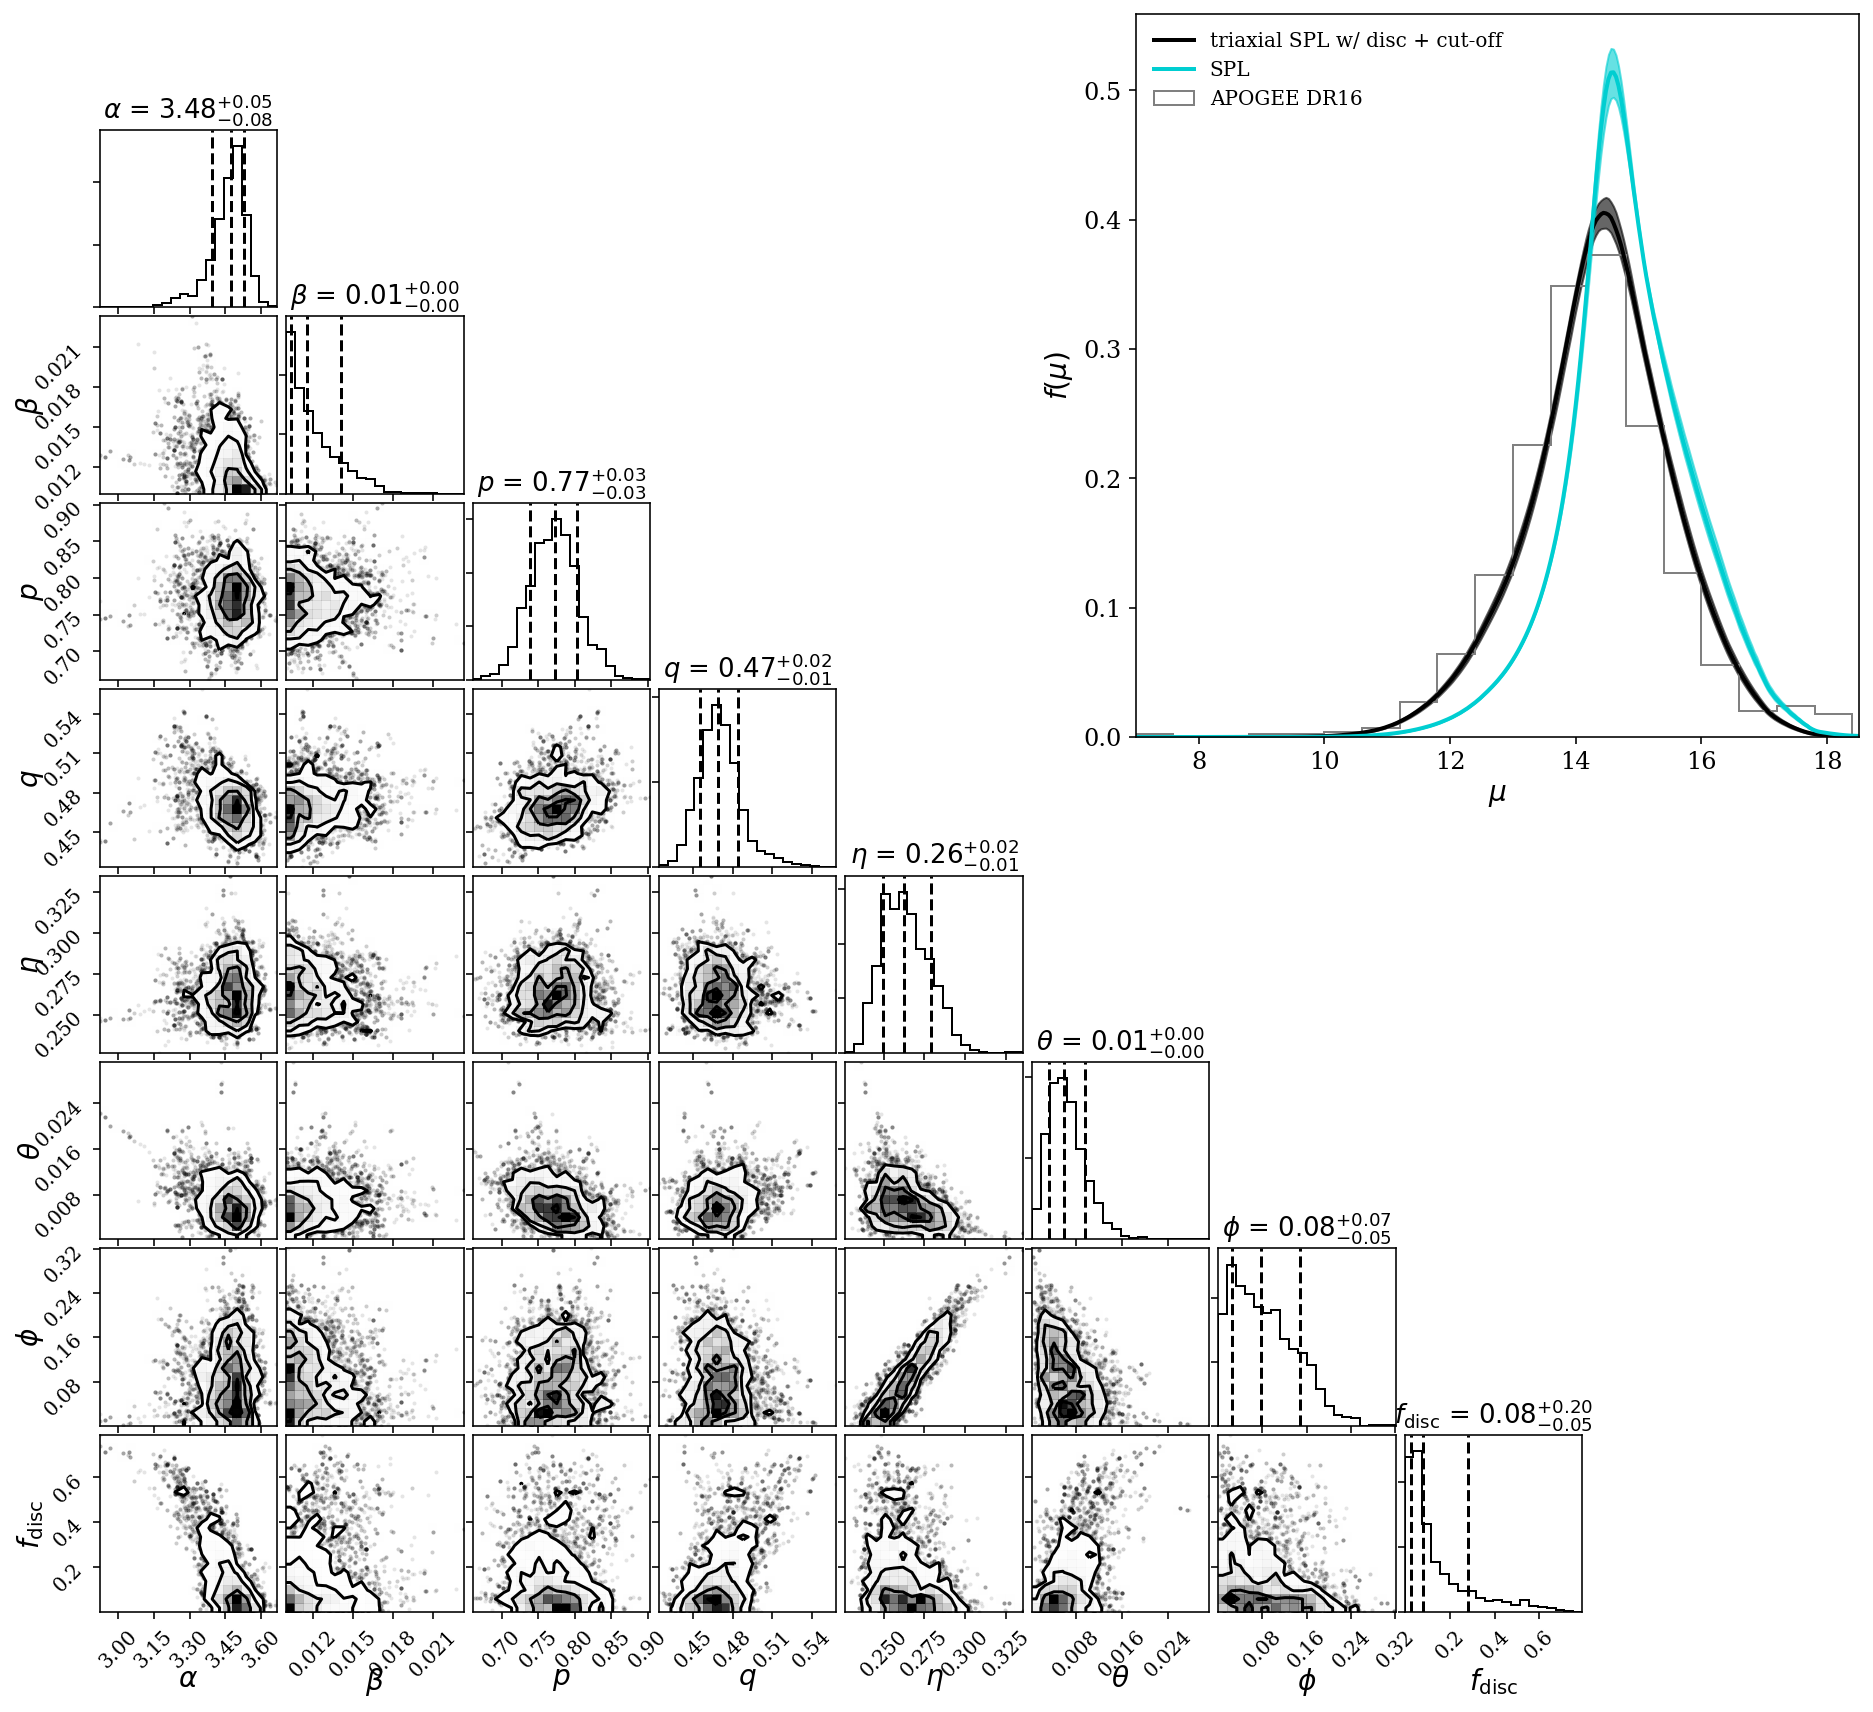

In [66]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params))*effsel[goodindx]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

halopd = check_fit(~nrichIndx, halosamples, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
halopd2 = check_fit(~nrichIndx, halosamples2, outarea, densprofiles.spherical, distmods, sample=True)


labels = [r'$\alpha$',r'$\beta$', r'$p$', r'$q$', r'$\eta$', r'$\theta$', r'$\phi$', r'$f_\mathrm{disc}$']
# labels = [r'$\alpha$']
fig = corner.corner(halosamples, show_titles=True, quantiles=[0.16,0.5,0.84], labels=labels, title_kwargs={"fontsize": 13})#fontsize=36)

for ax in fig.get_axes():
    ax.tick_params(axis='both',labelsize=10)
# from matplotlib import rcParams

# rcParams["font.size"] = 12
# rcParams["axes.labelpad"] = 7


ax = fig.add_axes([.7,.6,0.45,0.45])
# axes = fig.get_axes()[0]

data_distmod= 5*np.log10(allstar_f[haloIndx]['weighted_dist'][~nrichIndx])-5
print(len(data_distmod))
ax.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=20, color='gray', histtype='step', label='APOGEE DR16')
ax.plot(distmods,np.nanpercentile(halopd,50,axis=0),lw=2., color='k', label=r'triaxial SPL w/ disc + cut-off')
ax.fill_between(distmods,np.nanpercentile(halopd,5,axis=0),np.nanpercentile(halopd,95,axis=0), color='k', alpha=0.6)
ax.plot(distmods,np.nanpercentile(halopd2,50,axis=0), lw=2., color='darkturquoise', label='SPL')
ax.fill_between(distmods,np.nanpercentile(halopd2,5,axis=0),np.nanpercentile(halopd2,95,axis=0), color='darkturquoise',alpha=0.6)
ax.set_xlim(7,18.5)
ax.legend(frameon=False, loc=2,fontsize=10)
ax.set_xlabel(r'$\mu$',fontsize=14)
ax.set_ylabel(r'$f(\mu)$',fontsize=14)
ax.tick_params(labelsize=12)
# axes.tick_params(labelsize=16)

fig.set_size_inches(1.6*textwidth,1.6*textwidth)

# plt.savefig('../plots/halo_corner_new.png', format='png', dpi=400, bbox_inches='tight')



# Now repeat the fitting procedure for the N-rich stars. However, since we don't know the best fitting density profile (functional form at least), we will fit several different profiles and compare them

number of stars in full Fe/H range: 46


Text(0, 0.5, '$z\\ \\mathrm{[kpc]}$')

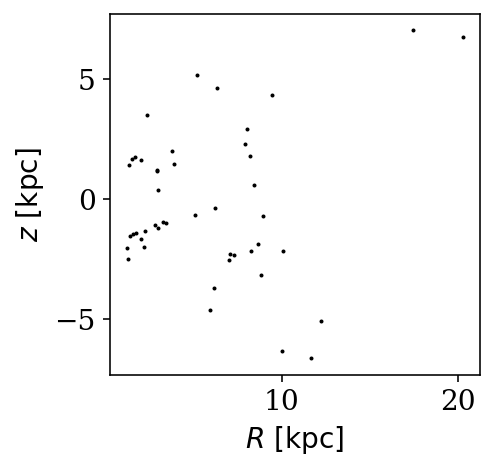

In [67]:
# REPEAT THE PROCEDURE FOR THE NRICH STARS
print('number of stars in full Fe/H range: '+str(sum(nrichIndx))+'')
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
plt.scatter(Rphiz[:,0][nrichIndx], Rphiz[:,2][nrichIndx], s=1,c='k')
plt.xlabel(r'$R\ \mathrm{[kpc]}$')
plt.ylabel(r'$z\ \mathrm{[kpc]}$')

In [68]:
# triaxial+rot+cutoff+disc
nrichopt, nrichsamples, nrichmasses, nrichfacs = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.,0.1,0.5,0.5,0.1,0.1,0.5,0.01], ncut=100, analytic=False)


46
<function fit_bin_mask.<locals>.<lambda> at 0x36908b560>
[4.35713548e+00 1.06467269e-02 5.19654254e-01 3.81483520e-01
 2.07230999e-01 1.32162796e-02 9.60237511e-01 8.08928546e-11]


In [69]:
# spherical
nrichopt2, nrichsamples2, nrichmasses2, nrichfacs2 = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.spherical, just_MLE=False, just_MCMC=False, mass=True, init= [2.], ncut=100, analytic=True)

46
<function fit_bin_mask.<locals>.<lambda> at 0x36908b680>
Optimization terminated successfully.
         Current function value: 536.310825
         Iterations: 17
         Function evaluations: 34
[3.85498047]


In [70]:
# triaxial
nrichopt3, nrichsamples3, nrichmasses3, nrichfacs3 = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.triaxial_norot, just_MLE=False, just_MCMC=False, mass=True, init= [2.,0.5,0.5], ncut=100, analytic=False)


46
<function fit_bin_mask.<locals>.<lambda> at 0x36908bd40>
Optimization terminated successfully.
         Current function value: 516.520928
         Iterations: 78
         Function evaluations: 140
[4.5561135  0.85622811 0.44384942]


In [75]:
# broken power law
nrichopt4, nrichsamples4, nrichmasses4, nrichfacs4 = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.broken_spl, just_MLE=False, just_MCMC=False, mass=True, init= [2.,3.,5.], ncut=100, analytic=True)


46
<function fit_bin_mask.<locals>.<lambda> at 0x3690c08c0>
Optimization terminated successfully.
         Current function value: 535.277859
         Iterations: 56
         Function evaluations: 109
[2.36958955 4.08753136 3.1072062 ]


In [71]:
# axisymmetric
nrichopt5, nrichsamples5, nrichmasses5, nrichfacs5 = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.axisymmetric, just_MLE=False, just_MCMC=False, mass=True, init= [2.,0.5], ncut=100, analytic=True)


46
<function fit_bin_mask.<locals>.<lambda> at 0x36908be60>
Optimization terminated successfully.
         Current function value: 517.016810
         Iterations: 39
         Function evaluations: 76
[4.48515552 0.46829804]


In [72]:
# justexpdisk
nrichopt6, nrichsamples6, nrichmasses6, nrichfacs6 = fit_bin_mask(nrichIndx, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.justexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [1/1.8,1/0.8], ncut=100, analytic=True)


46
<function fit_bin_mask.<locals>.<lambda> at 0x36908b560>
Optimization terminated successfully.
         Current function value: 529.038504
         Iterations: 33
         Function evaluations: 64
[0.41075541 0.63824324]


# Now let's figure out which is the best fitting density model to our N-rich star sample

To do so, we will use the mean of the posterior samples obtained by fitting each profile (i.e. nrichsamples). We will then compute the BIC and log likelihood following the Schwartz convention.

In [76]:
def calc_bic_loglike(mask, params, fehrange=[-1.6,-1.], effsel=outarea, model = densprofiles.spherical):
    loglike = utils.loglike(params,model, effsel[goodindx]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
    print((sum(mask)))
    bic = sum(params)*np.log(sum(mask))-2*loglike
    return bic, loglike

In [77]:
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk)
print('Triaxial+rot+disc+cut-off')
print(nbic,nloglike)
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples2,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.spherical)
print('spherical')
print(nbic,nloglike)
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples3,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.triaxial_norot)
print('Triaxial')
print(nbic,nloglike)
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples4,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.broken_spl)
print('broken spl')
print(nbic,nloglike)
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples5,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.axisymmetric)
print('axisymmetric')
print(nbic,nloglike)
nbic, nloglike = calc_bic_loglike(nrichIndx,params=np.median(nrichsamples6,axis=0),fehrange=[-3.,-1.],effsel=outarea, model = densprofiles.justexpdisk)
print('Exp disc')
print(nbic,nloglike)

46
Triaxial+rot+disc+cut-off
1062.3899270895618 -518.6050186582531
46
spherical
1087.3499383314781 -536.3118301564401
46
Triaxial
1055.2573612509018 -516.5770146847806
46
broken spl
1128.9033262236221 -531.6446877956221
46
axisymmetric
1053.0146584971997 -517.0264123123684
46
Exp disc
1062.1444453356444 -529.0443645503592


# Since we found the axisymmetric profile to be the best fit, let's look at the resulting samples from the fit

# Make the diagnostics of the MCMC (i.e. corner plots):

46



46


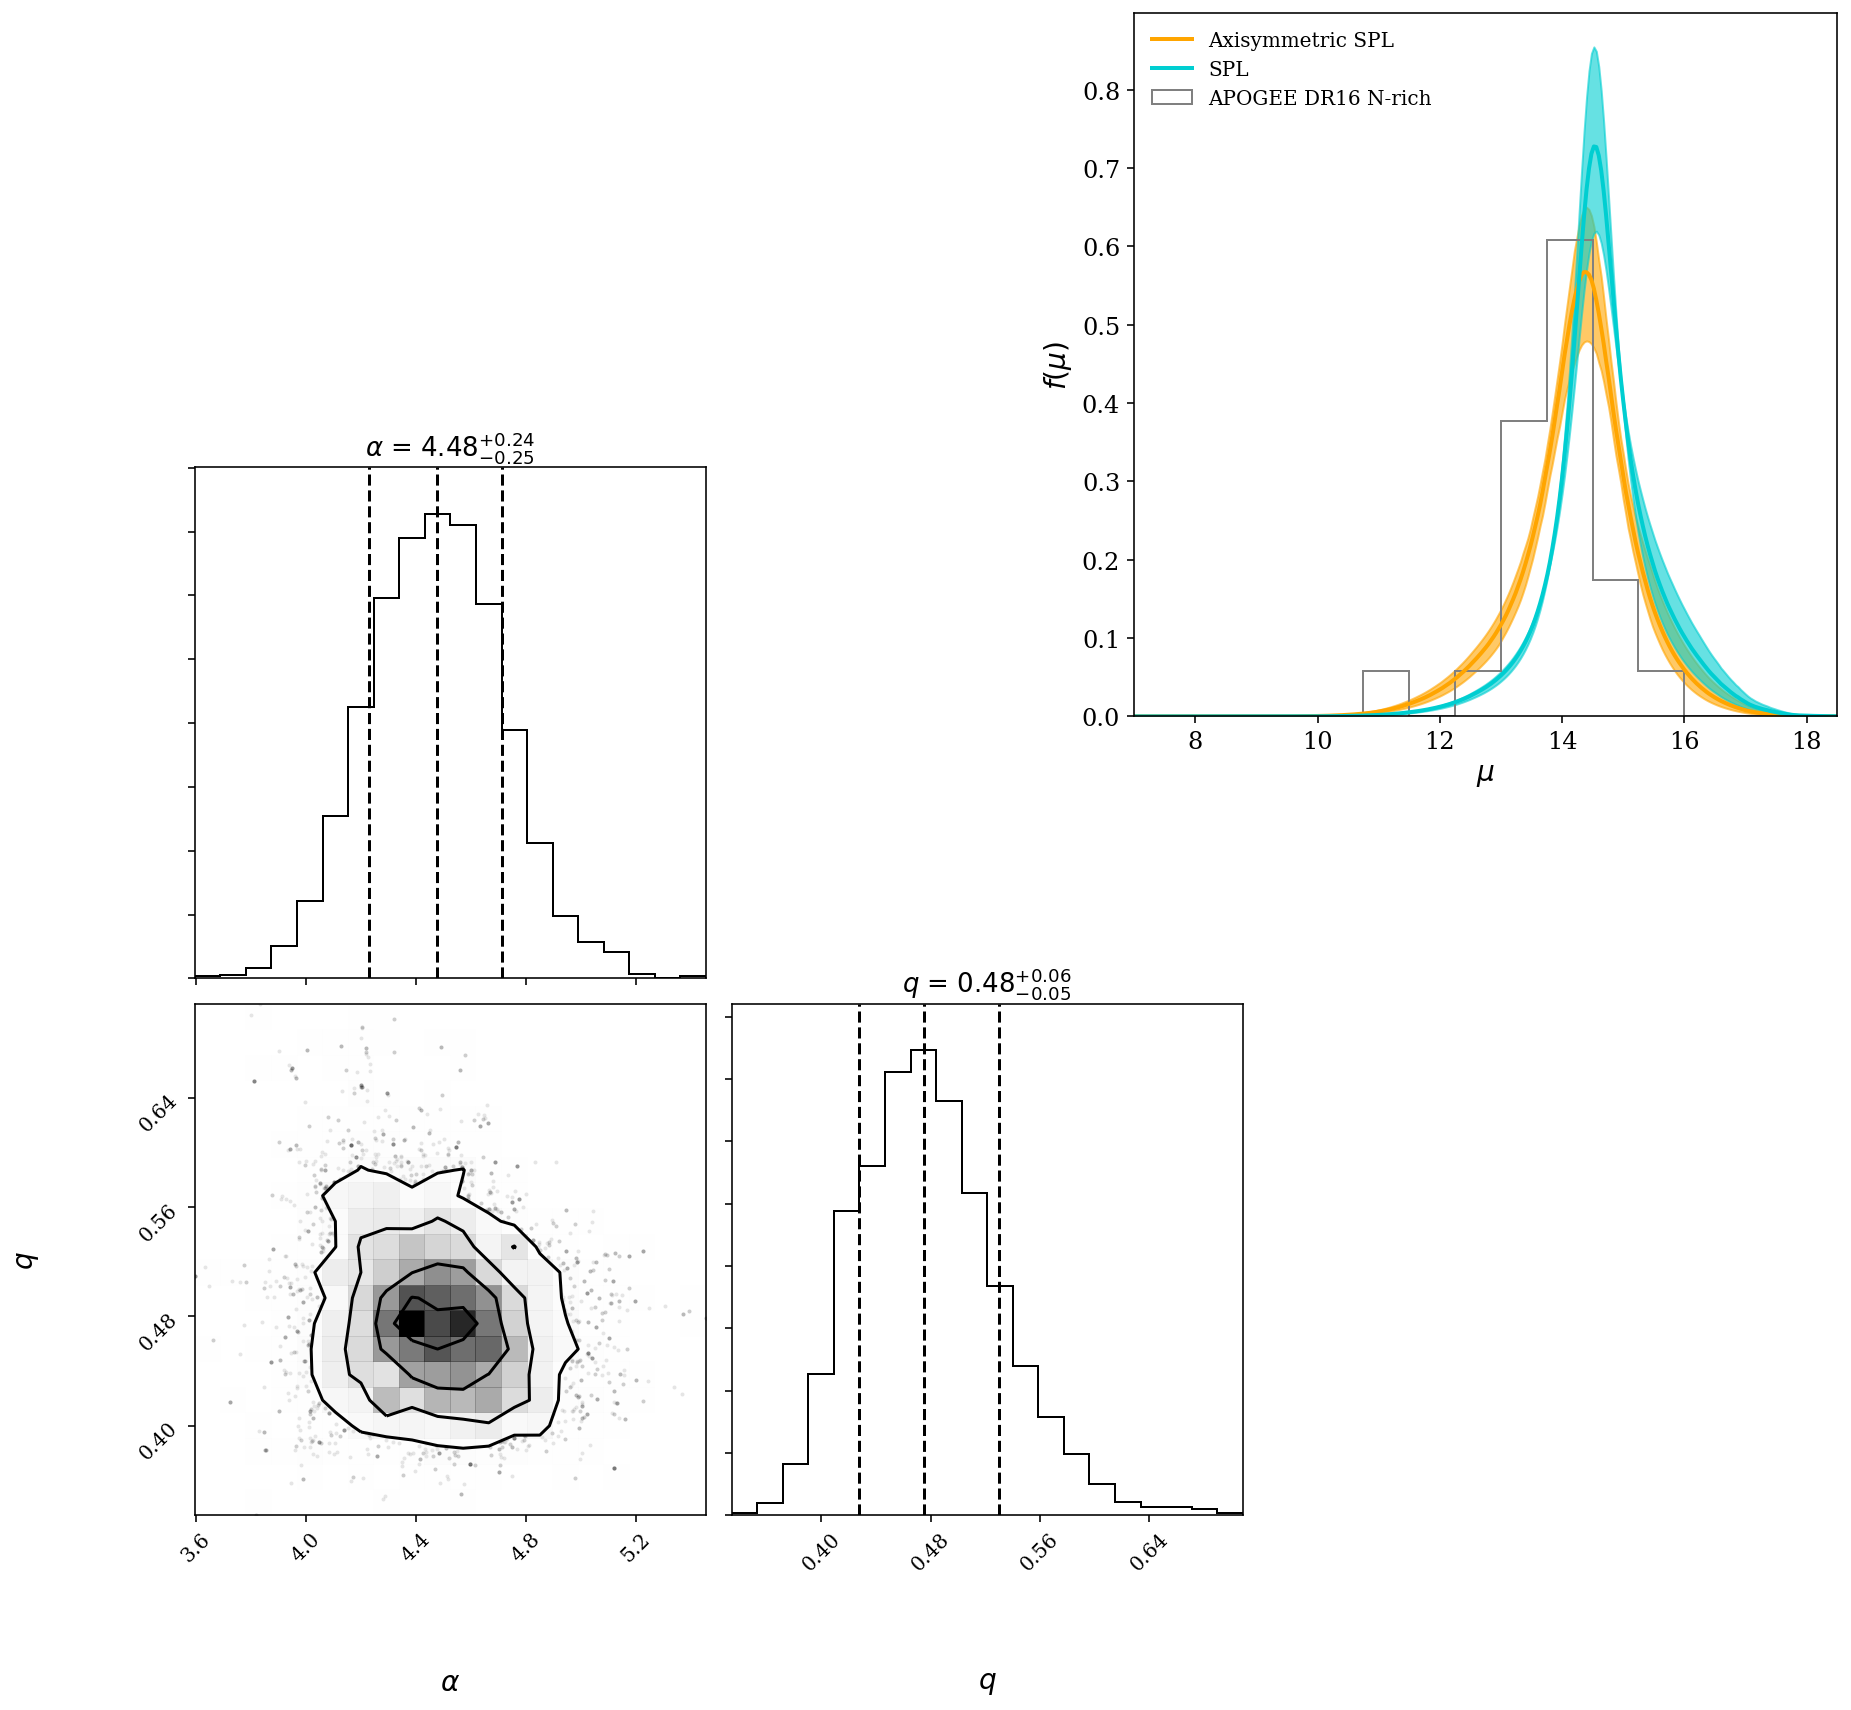

In [80]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params))*effsel[goodindx]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

nrichpd = check_fit(nrichIndx, nrichsamples5, outarea, densprofiles.axisymmetric, distmods, sample=True)
nrichpd2 = check_fit(nrichIndx, nrichsamples2, outarea, densprofiles.spherical, distmods, sample=True)

# labels = [r'$\alpha$',r'$\beta\ \mathrm{[kpc^{-1}]}$', r'$p$', r'$q$', r'$\eta$', r'$\theta$', r'$\phi$', r'$f_\mathrm{disc}$']
labels = [r'$\alpha$',r'$q$']


fig = corner.corner(nrichsamples5, show_titles=True, quantiles=[0.16,0.5,0.84], labels=labels, title_kwargs={"fontsize": 13})

for ax in fig.get_axes():
    ax.tick_params(axis='both',labelsize=10)
    
ax = fig.add_axes([.85,.75,0.5,0.5])

data_distmod= 5*np.log10(allstar_f[haloIndx]['weighted_dist'][nrichIndx])-5
# print(len(data_distmod))
ax.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step', label='APOGEE DR16 N-rich')
ax.plot(distmods,np.nanpercentile(nrichpd,50,axis=0),lw=2., color='orange', label=r'Axisymmetric SPL')
ax.fill_between(distmods,np.nanpercentile(nrichpd,5,axis=0),np.nanpercentile(nrichpd,95,axis=0), color='orange', alpha=0.6)
ax.plot(distmods,np.nanpercentile(nrichpd2,50,axis=0), lw=2., color='darkturquoise', label='SPL')
ax.fill_between(distmods,np.nanpercentile(nrichpd2,5,axis=0),np.nanpercentile(nrichpd2,95,axis=0), color='darkturquoise',alpha=0.6)
ax.set_xlim(7,18.5)
ax.tick_params(labelsize=12)
ax.legend(frameon=False, loc=2, fontsize=10)
ax.set_xlabel(r'$\mu$',fontsize=14)
ax.set_ylabel(r'$f(\mu)$',fontsize=14)

fig.set_size_inches(1.4*textwidth,1.4*textwidth)

# plt.savefig('../plots/nrich_corner_new.png', format='png', dpi=400, bbox_inches='tight')



In [81]:
# get the halo normalisation and total mass for the best fit profile
percen1 = np.percentile(nrichfacs*1e-9,[16,50,84])
percen2 = np.percentile(nrichmasses,[16,50,84])
print(percen1)
print(percen2)


[2.50411267e-06 4.35432163e-06 6.52166649e-06]
[  219143.49950689 54182764.23673031 76213452.36065732]


# Compute the density given by the samples in the parameters and random normalisation factors, using the best fit profile

# For the halo field

In [82]:
model = densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk
rs = np.linspace(1.5,20.,150)
dens_halo = np.empty((300,150))
randomfac = halofacs[np.random.choice(len(halofacs), 300, replace=False)]
for ii,param in enumerate(halosamples[np.random.choice(len(halosamples), 300, replace=False)]):
    dens_halo[ii] = model(rs, np.zeros(len(rs)), np.zeros(len(rs)), params=param,split=True)[0]*randomfac[ii]
    

# For the N-rich stars

In [83]:
# take samples of the density given by the samples in the parameters and random normalisation factors
model = densprofiles.axisymmetric
rs = np.linspace(1.5,20.,150)
dens_nrich = np.empty((300,150))
randomfac = nrichfacs[np.random.choice(len(nrichfacs), 300, replace=False)]
for ii,param in enumerate(nrichsamples[np.random.choice(len(nrichsamples), 300, replace=False)]):
    dens_nrich[ii] = model(rs, np.zeros(len(rs)), np.zeros(len(rs)), params=param)*randomfac[ii]
    

# Let's calculate the masses of -3 < [Fe/H] < -1 for halo field and N-rich between 1.5 and 20 kpc and take the mass density ratios

In [85]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[1.5:20:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (20-1.5)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = bovy_coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(1.5,20,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.**2+0.02**2)
                alpha = param[0]
                max_r = 20.
                min_r = 1.5
                r = np.linspace(1.5,20,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        elif model is densprofiles.axisymmetric or densprofiles.triaxial_norot:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param,split=True)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses


In [86]:
haloradmasses = calc_masses(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, halofacs, halosamples)



In [87]:
nrichradmasses = calc_masses(densprofiles.axisymmetric, nrichfacs5, nrichsamples5)


In [114]:
# calculate the mass in 20kpc from halo 
print('Within 20kpc')
halomass = np.sum(haloradmasses,axis=1)*(20-1.5)/149
print(np.percentile(halomass,[16,50,84]))
# calculate the mass in 3kpc from halo
print('Within 3 kpc')
halomass = np.sum(haloradmasses[:,:12],axis=1)*(20-1.5)/149
print(np.percentile(halomass,[16,50,84]))

print('Within 4 kpc')
halomass = np.sum(haloradmasses[:,:20],axis=1)*(20-1.5)/149
print(np.percentile(halomass,[16,50,84]))

Within 20kpc
[7.35721885e+08 8.56189164e+08 1.05009523e+09]
Within 3 kpc
[2.97956750e+08 3.62315597e+08 4.46967591e+08]
Within 4 kpc
[4.00740655e+08 4.75762660e+08 5.89868905e+08]


In [115]:
# calculate the mass in 20kpc from N-Rich 
print('Within 20kpc')
nrichmass = np.sum(nrichradmasses,axis=1)*(20-1.5)/149
print(np.percentile(nrichmass,[16,50,84]))
# calculate the mass in 3kpc from N-Rich 
print('Within 3 kpc')
nrichmass = np.sum(nrichradmasses[:,:12],axis=1)*(20-1.5)/149
print(np.percentile(nrichmass,[16,50,84]))
print('Within 4 kpc')
nrichmass = np.sum(nrichradmasses[:,:20],axis=1)*(20-1.5)/149
print(np.percentile(nrichmass,[16,50,84]))


Within 20kpc
[45355130.02415902 65925657.1095638  91613278.2368182 ]
Within 3 kpc
[28405212.68477041 43173777.87633376 63523142.34762152]
Within 4 kpc
[34409119.70693256 51523933.00369322 74104520.86593336]


# Let's now compute the mass and volume in spherical shells, so we can then determine the integrated mass in spherical shells as a function of distance from the Galactic centre

In [93]:
# define the shell volumes for which to integrate the mass and density over
rs = np.linspace(1.5,20,150)
shell_volumes = np.zeros(len(rs))
dr = (20-1.5)/149
shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]

shell_halomasses = haloradmasses/shell_volumes
shell_nrichmasses = nrichradmasses/shell_volumes

In [94]:
percentiles_halo_masses_shell = np.percentile(shell_halomasses,[16,50,84], axis=0)
percentiles_nrich_masses_shells = np.percentile(shell_nrichmasses,[16,50,84], axis=0)


(1, 20)

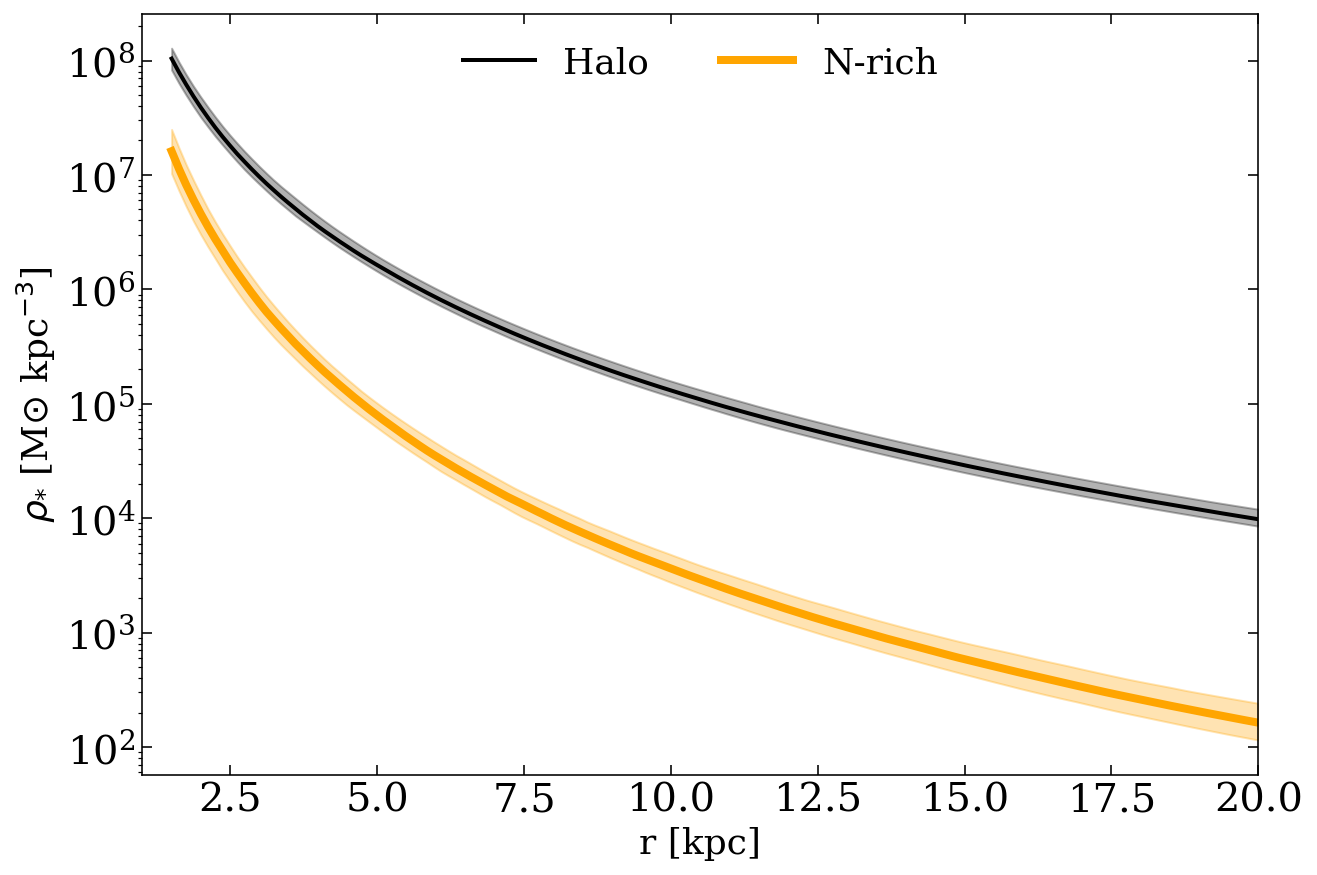

In [95]:
plt.figure(figsize=(10,7))
plt.rc('font',family='serif',size=14)
plt.plot(rs,percentiles_halo_masses_shell[1],label='Halo',c='k',lw=2)
plt.fill_between(rs,percentiles_halo_masses_shell[0],percentiles_halo_masses_shell[2],alpha=0.3,color='k')
plt.plot(rs,percentiles_nrich_masses_shells[1],label='N-rich',c='orange',lw=4)
plt.fill_between(rs,percentiles_nrich_masses_shells[0],percentiles_nrich_masses_shells[2],alpha=0.3,color='orange')
plt.xlabel(r'r [kpc]',fontsize=18)
plt.legend(fontsize=18,ncol=2,loc='upper center',frameon=False)
plt.tick_params(labelsize=20)
plt.ylabel(r'$\rho_{*}$ [M$\odot$ kpc$^{-3}$]',fontsize=18)
plt.yscale('log')
plt.tick_params(direction='in', right=True,top=True,length=5)
plt.xlim(1,20)

# plt.savefig('../plots/spherical_annuli_mass_15kpc.pdf', format='pdf', dpi=400, bbox_inches='tight')


In [96]:
mass_ratio_shell = shell_nrichmasses/shell_halomasses
percentiles_massratio_shell = np.percentile(mass_ratio_shell,[16,50,84], axis=0)

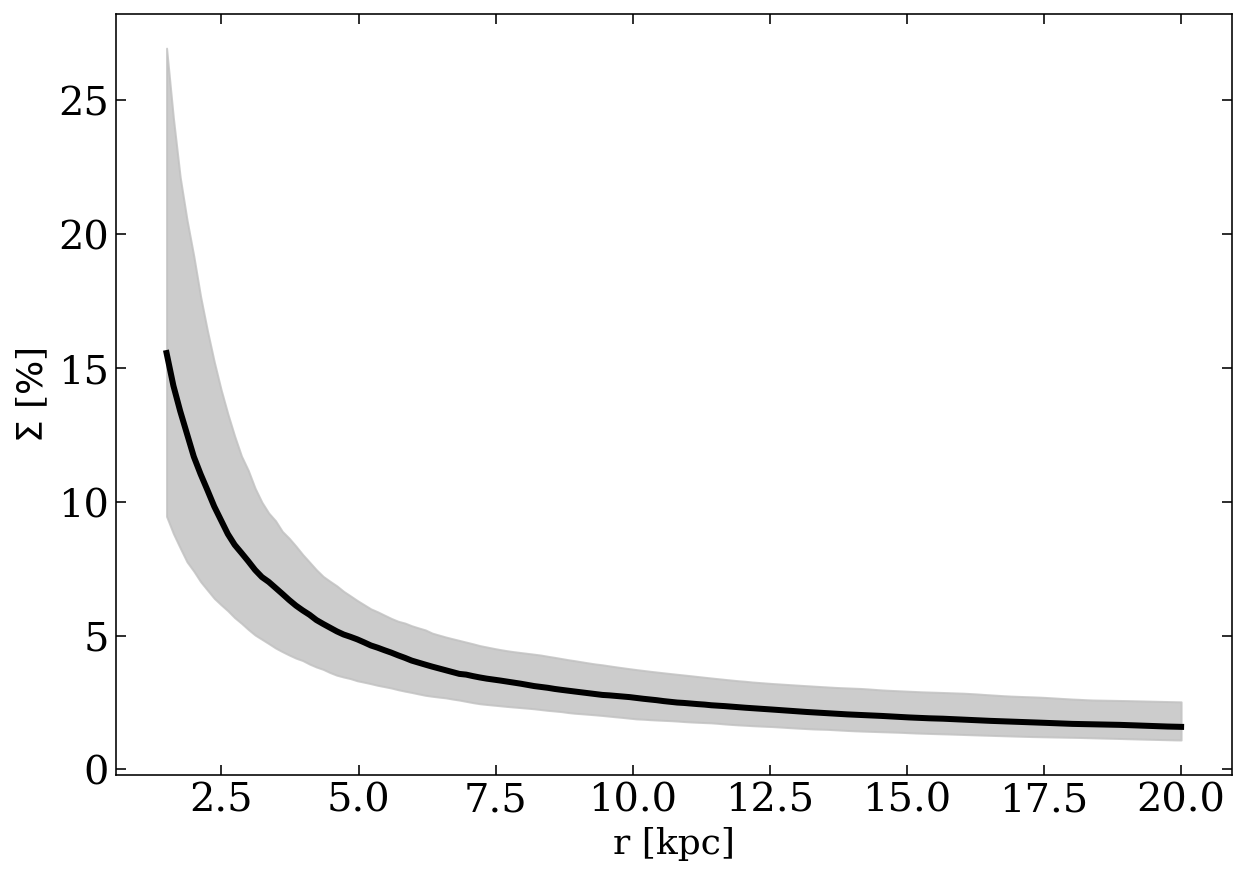

In [97]:
rs = np.linspace(1.5,20,150)
plt.figure(figsize=(10,7))
plt.rc('font',family='serif',size=14)
plt.fill_between(rs,percentiles_massratio_shell[0]*100,percentiles_massratio_shell[2]*100,alpha=0.8,color='silver')
plt.plot(rs,percentiles_massratio_shell[1]*100,c='k',label='Modelled',linewidth=3)

plt.xlabel(r'r [kpc]',fontsize=18)
plt.ylabel(r'$\zeta$ [$\%$]',fontsize=18)
plt.tick_params(labelsize=20)
plt.tick_params(direction='in', right=True,top=True,length=5)

# plt.savefig('../plots/spherical_annuli_ratio.pdf', format='pdf', dpi=400, bbox_inches='tight')


Print the ratios of N-rich stars to halo field at different radii

In [113]:
# print the ratio at 3 kpc
print(percentiles_massratio_shell[0,12]*100,percentiles_massratio_shell[1,12]*100,percentiles_massratio_shell[2,12]*100)
# print the ratio at 4 kpc
print(percentiles_massratio_shell[0,20]*100,percentiles_massratio_shell[1,20]*100,percentiles_massratio_shell[2,20]*100)
# print the ratio at 20 kpc
print(percentiles_massratio_shell[0,-1]*100,percentiles_massratio_shell[1,-1]*100,percentiles_massratio_shell[2,-1]*100)
# print the ratio at 1.5 kpc
print(percentiles_massratio_shell[0,0]*100,percentiles_massratio_shell[1,0]*100,percentiles_massratio_shell[2,0]*100)
# print the ratio at 15 kpc
print(percentiles_massratio_shell[0,108]*100,percentiles_massratio_shell[1,108]*100,percentiles_massratio_shell[2,108]*100)
# print the ratio at 8 kpc
print(percentiles_massratio_shell[0,52]*100,percentiles_massratio_shell[1,52]*100,percentiles_massratio_shell[2,52]*100)



5.227396644538289 7.776506408387222 11.173268326481907
4.0632610927471235 5.9381359452691145 8.025633366422209
1.0940390180398272 1.5854361470066913 2.520581080812351
9.453312471894678 15.558697008075569 26.95549164467742
1.3788812724725272 1.9505309744810204 2.9294034824534925


In [99]:
# print the ratio at 3 kpc
print(percentiles_massratio_shell[0,12]*150,percentiles_massratio_shell[1,12]*150,percentiles_massratio_shell[2,12]*150)
# print the ratio at 20 kpc
print(percentiles_massratio_shell[0,-1]*150,percentiles_massratio_shell[1,-1]*150,percentiles_massratio_shell[2,-1]*150)
# print the ratio at 1.5 kpc
print(percentiles_massratio_shell[0,0]*150,percentiles_massratio_shell[1,0]*150,percentiles_massratio_shell[2,0]*150)
# print the ratio at 15 kpc
print(percentiles_massratio_shell[0,108]*150,percentiles_massratio_shell[1,108]*150,percentiles_massratio_shell[2,108]*150)
# print the ratio at 8 kpc
print(percentiles_massratio_shell[0,52]*150,percentiles_massratio_shell[1,52]*150,percentiles_massratio_shell[2,52]*150)



7.841094966807433 11.664759612580834 16.75990248972286
1.6410585270597409 2.378154220510037 3.7808716212185267
14.179968707842018 23.338045512113354 40.433237467016134
2.068321908708791 2.925796461721531 4.3941052236802385


# Re-assess everything with the triaxial and tri-cut-disc profiles (seen as they also fit the N-rich star distribution well)

In [100]:
nrichradmasses_tri = calc_masses(densprofiles.triaxial_norot, nrichfacs3, nrichsamples3)


In [101]:
nrichradmasses_tricut = calc_masses(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, nrichfacs, nrichsamples)


In [102]:
# define the shell volumes for which to integrate the mass and density over
shell_volumes = np.zeros(len(rs))
dr = (20-1.5)/149
shell_volumes = [((4*np.pi)/3)*(i+dr)**3-((4*np.pi)/3)*(i)**3 for i in rs]

shell_halomasses = haloradmasses/shell_volumes
shell_nrichmasses_tri = nrichradmasses_tri/shell_volumes
shell_nrichmasses_tricut = nrichradmasses_tricut/shell_volumes


In [103]:
percentiles_halo_masses_shells = np.percentile(shell_halomasses,[16,50,84], axis=0)
percentiles_nrich_masses_shell_tri = np.percentile(shell_nrichmasses_tri,[16,50,84], axis=0)
percentiles_nrich_masses_shell_tricut = np.percentile(shell_nrichmasses_tricut,[16,50,84], axis=0)


In [104]:
mass_ratio_shell_tri = shell_nrichmasses_tri/shell_halomasses
percentiles_massratio_shell_tri = np.percentile(mass_ratio_shell_tri,[16,50,84], axis=0)

mass_ratio_shell_tricut = shell_nrichmasses_tricut/shell_halomasses
percentiles_massratio_shell_tricut = np.percentile(mass_ratio_shell_tricut,[16,50,84], axis=0)


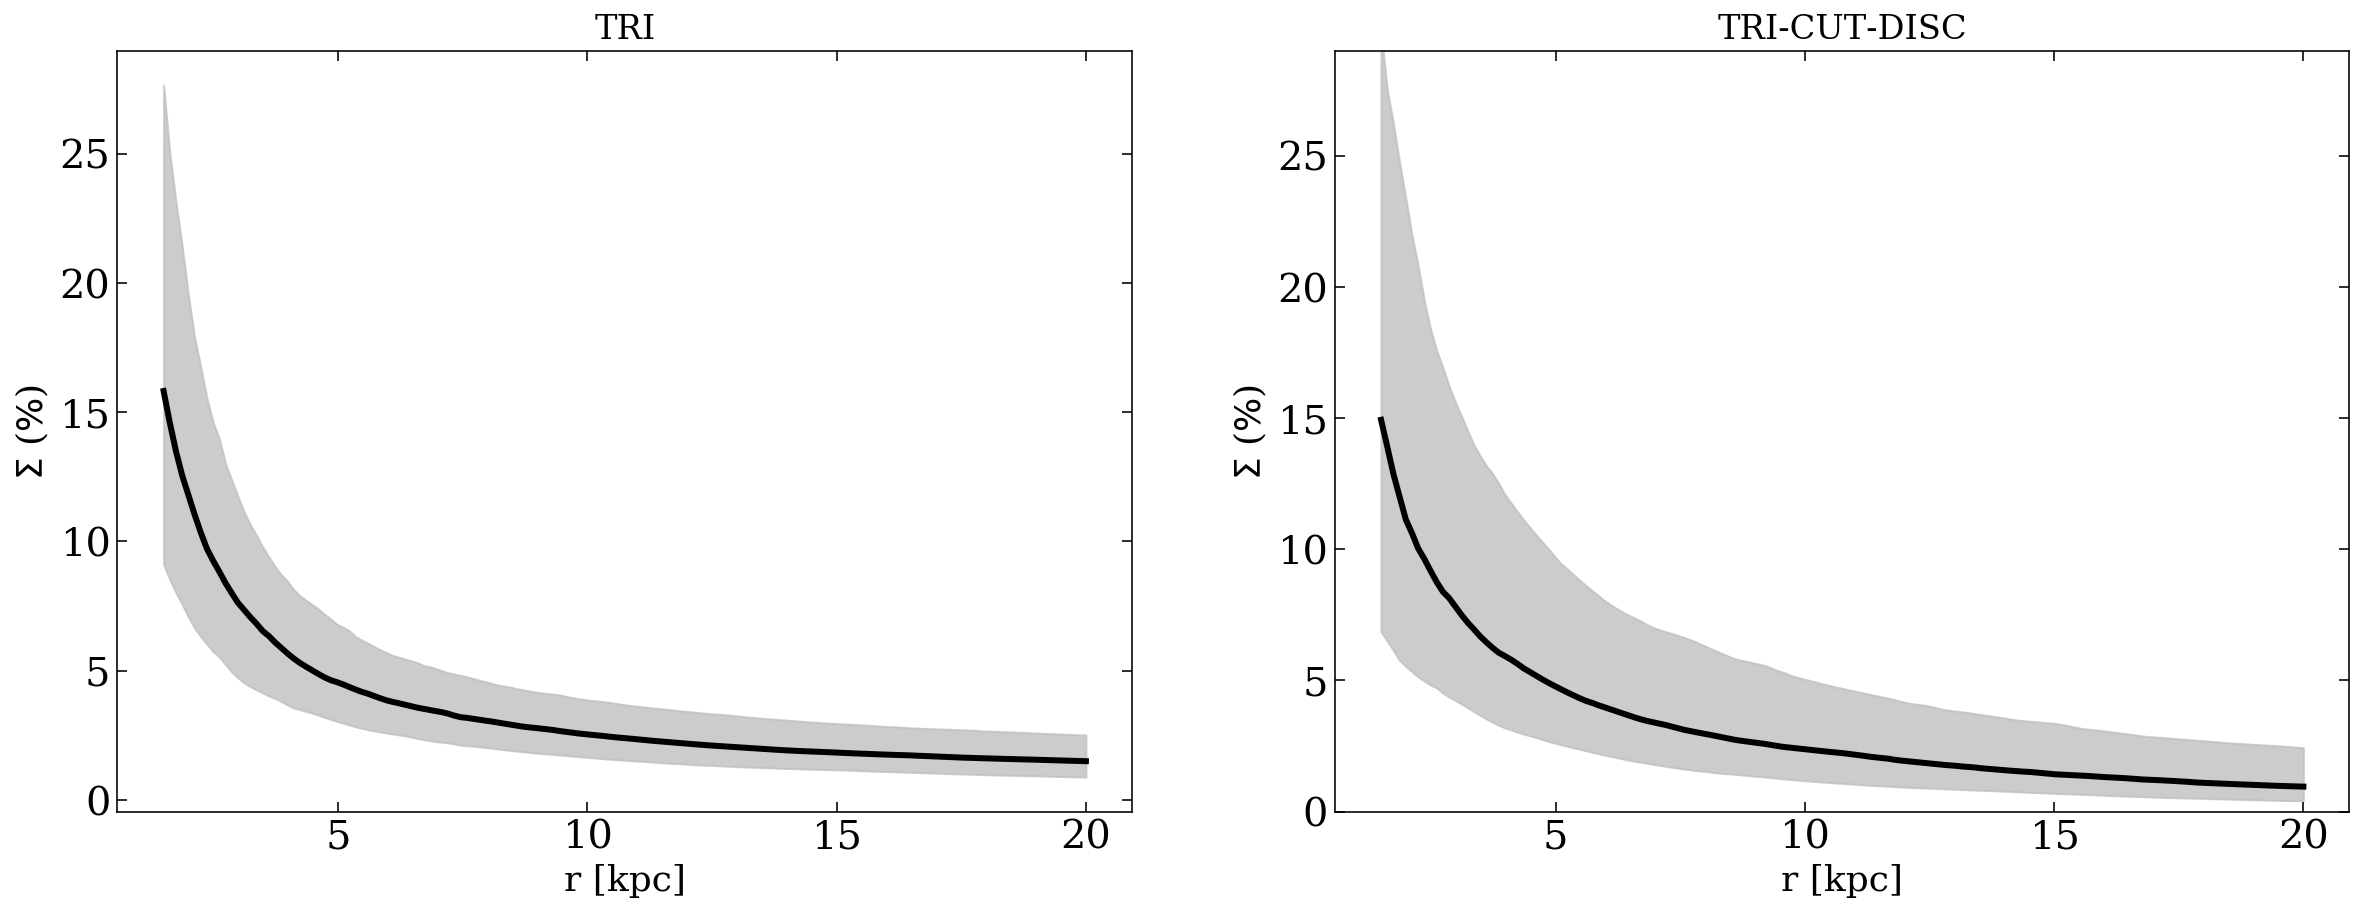

In [111]:
rs = np.linspace(1.5,20,150)
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('TRI')
plt.fill_between(rs,percentiles_massratio_shell_tri[0]*100,percentiles_massratio_shell_tri[2]*100,alpha=0.8,color='silver')
plt.plot(rs,percentiles_massratio_shell_tri[1]*100,c='k',label='Modelled',linewidth=3)
plt.xlabel(r'r [kpc]',fontsize=18)
plt.ylabel(r'$\zeta$ ($\%$)',fontsize=18)
plt.tick_params(labelsize=20)
plt.tick_params(direction='in', right=True,top=True,length=5)

plt.subplot(1,2,2)
plt.title('TRI-CUT-DISC')
plt.fill_between(rs,percentiles_massratio_shell_tricut[0]*100,percentiles_massratio_shell_tricut[2]*100,alpha=0.8,color='silver')
plt.plot(rs,percentiles_massratio_shell_tricut[1]*100,c='k',label='Modelled',linewidth=3)
plt.xlabel(r'r [kpc]',fontsize=18)
plt.ylabel(r'$\zeta$ ($\%$)',fontsize=18)
plt.tick_params(labelsize=20)
plt.ylim(0,29)
plt.tick_params(direction='in', right=True,top=True,length=5)

plt.savefig('../plots/spherical_annuli_ratio_v2.pdf', format='pdf', dpi=400, bbox_inches='tight')



# Plot the comparison of all the different profiles fitted to the N-rich sample

46



46



46



46



46



46


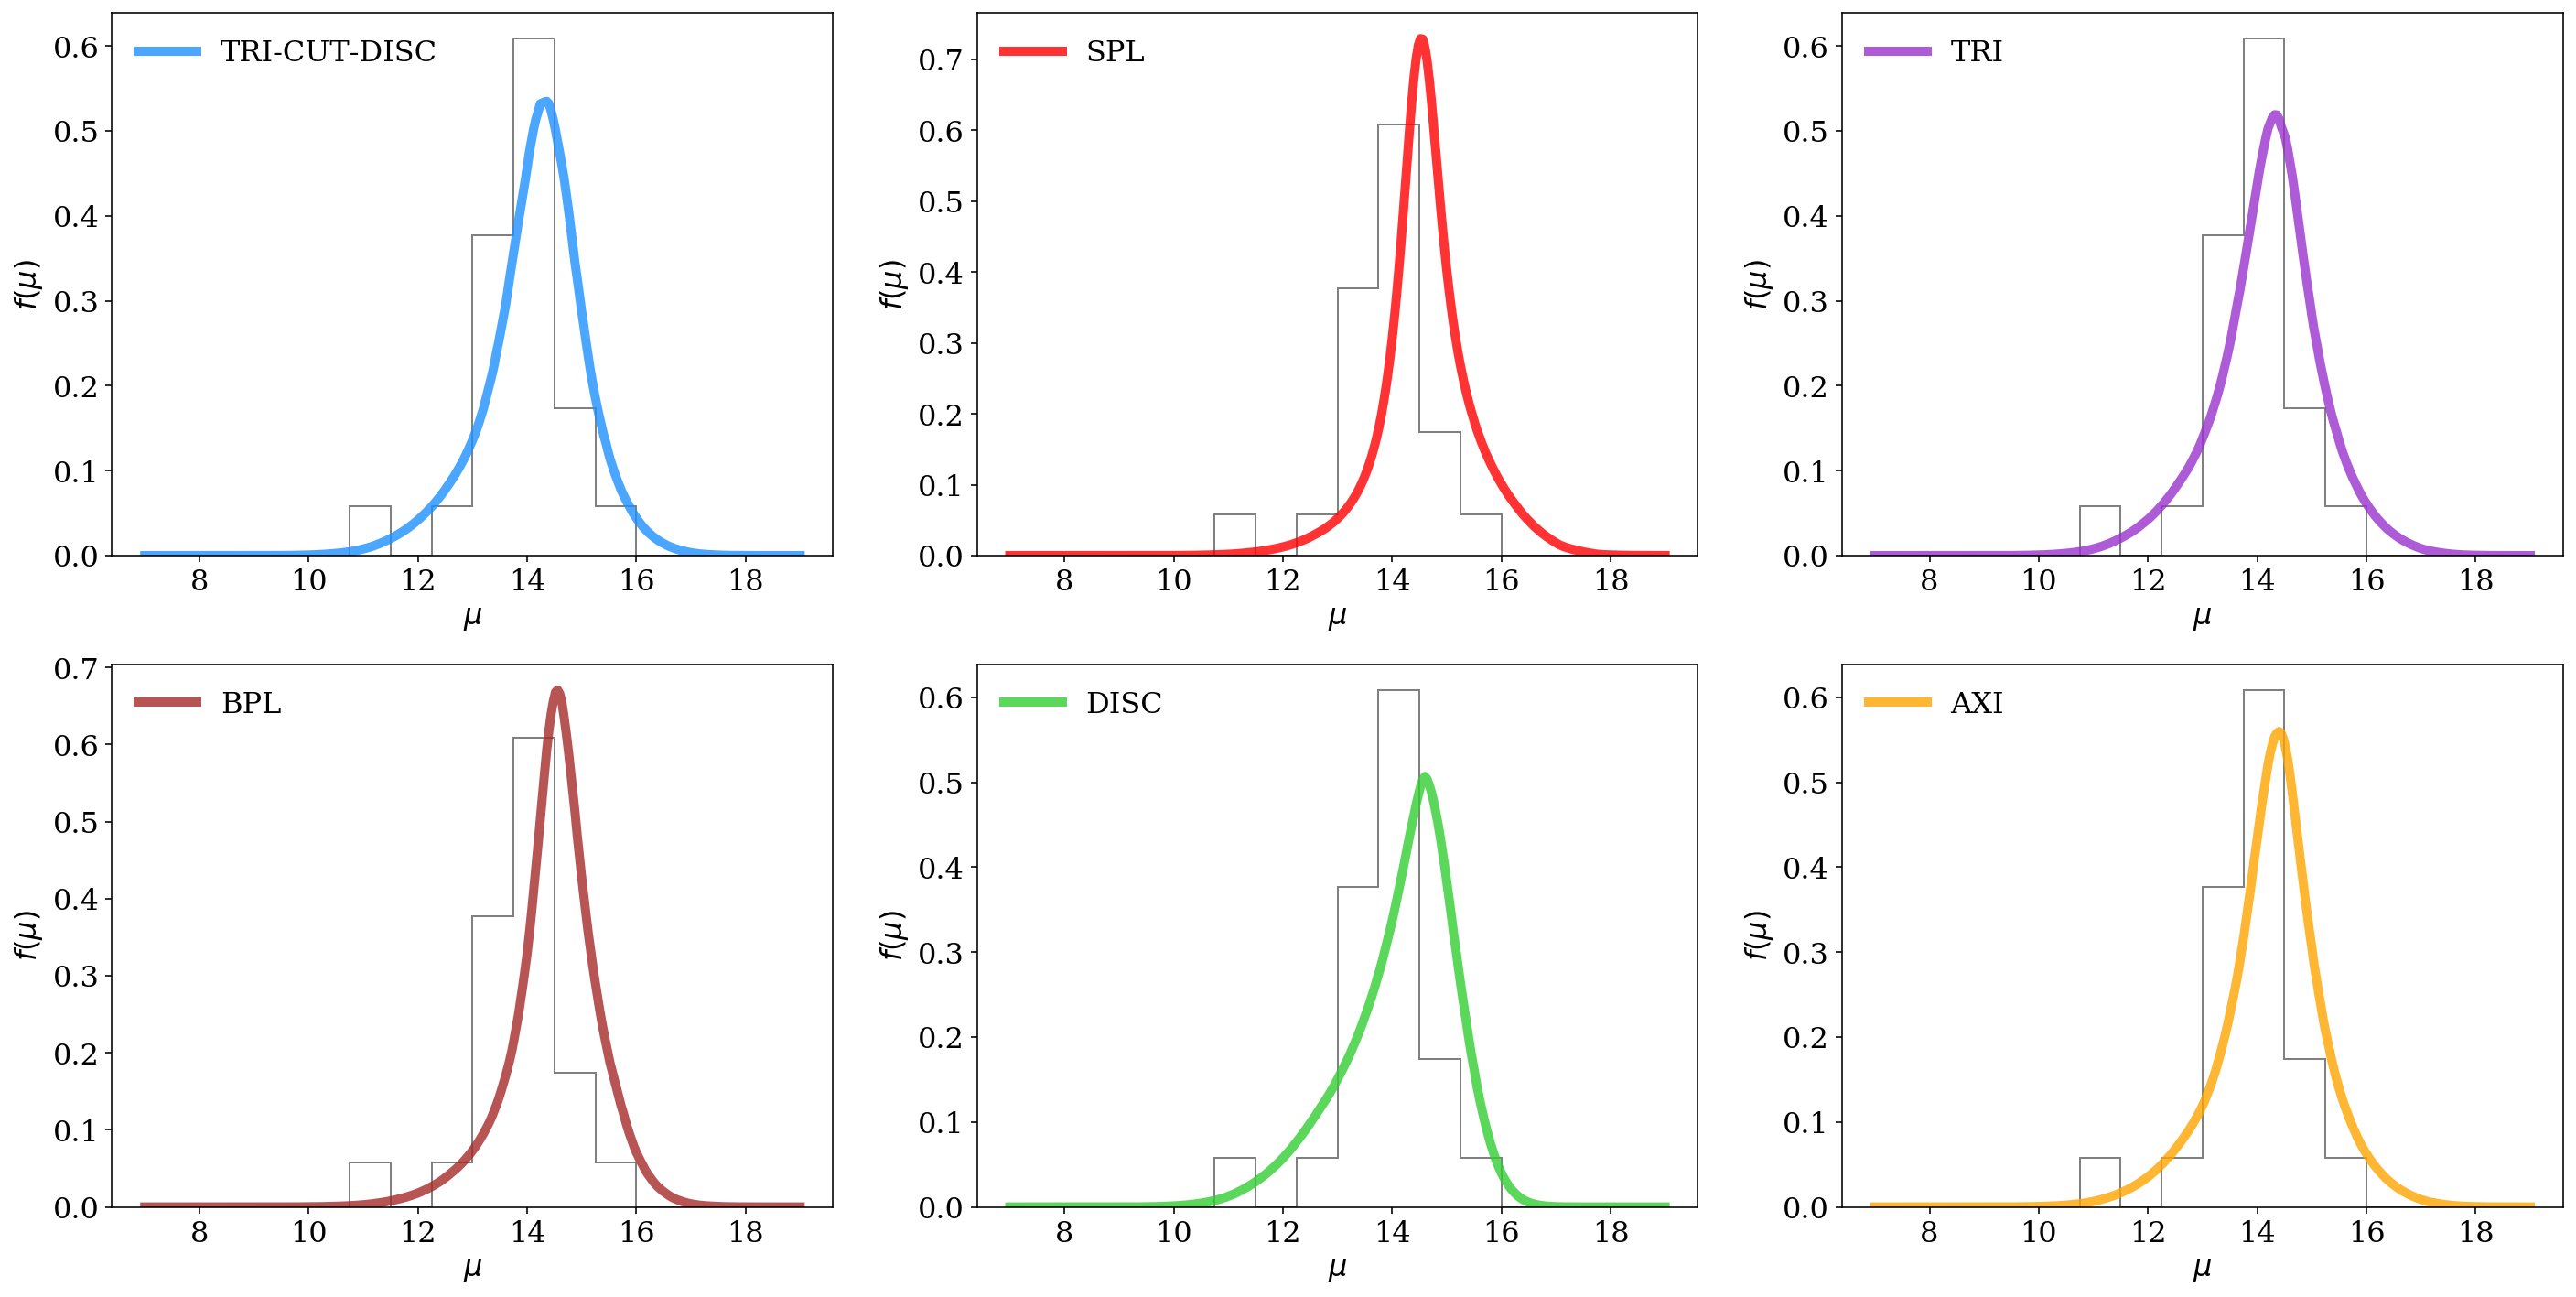

In [106]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params))*effsel[goodindx]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

# cut off
nrichpd9 = check_fit(nrichIndx, nrichsamples, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
# spherical
nrichpd10 = check_fit(nrichIndx, nrichsamples2, outarea, densprofiles.spherical, distmods, sample=True)
# tri
nrichpd11 = check_fit(nrichIndx, nrichsamples3, outarea, densprofiles.triaxial_norot, distmods, sample=True)
# axisymmetric
nrichpd = check_fit(nrichIndx, nrichsamples5, outarea, densprofiles.axisymmetric, distmods, sample=True)
# Broken tri+rot+disc
nrichpd12 = check_fit(nrichIndx, nrichsamples4, outarea, densprofiles.broken_spl, distmods, sample=True)
# expdisc
nrichpd8 = check_fit(nrichIndx, nrichsamples6, outarea, densprofiles.justexpdisk, distmods, sample=True)



data_distmod= 5*np.log10(allstar_f[haloIndx]['weighted_dist'][nrichIndx])-5
# print(len(data_distmod))

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd9,50,axis=0),lw=5., color='dodgerblue', label=r'TRI-CUT-DISC',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)
plt.subplot(2,3,2)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd10,50,axis=0),lw=5., color='red', label=r'SPL',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)
plt.subplot(2,3,3)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd11,50,axis=0),lw=5., color='darkorchid', label=r'TRI',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)
plt.subplot(2,3,4)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd12,50,axis=0),lw=5., color='brown', label=r'BPL',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)
plt.subplot(2,3,5)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd8,50,axis=0),lw=5., color='limegreen', label=r'DISC',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)
plt.subplot(2,3,6)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd,50,axis=0),lw=5., color='orange', label=r'AXI',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(loc='upper left',fontsize=16,frameon=False)

# plt.savefig('../plots/n_rich_models_comparison_combined.pdf', format='pdf', dpi=400, bbox_inches='tight')

plt.show()


46



46



46



46



46



46


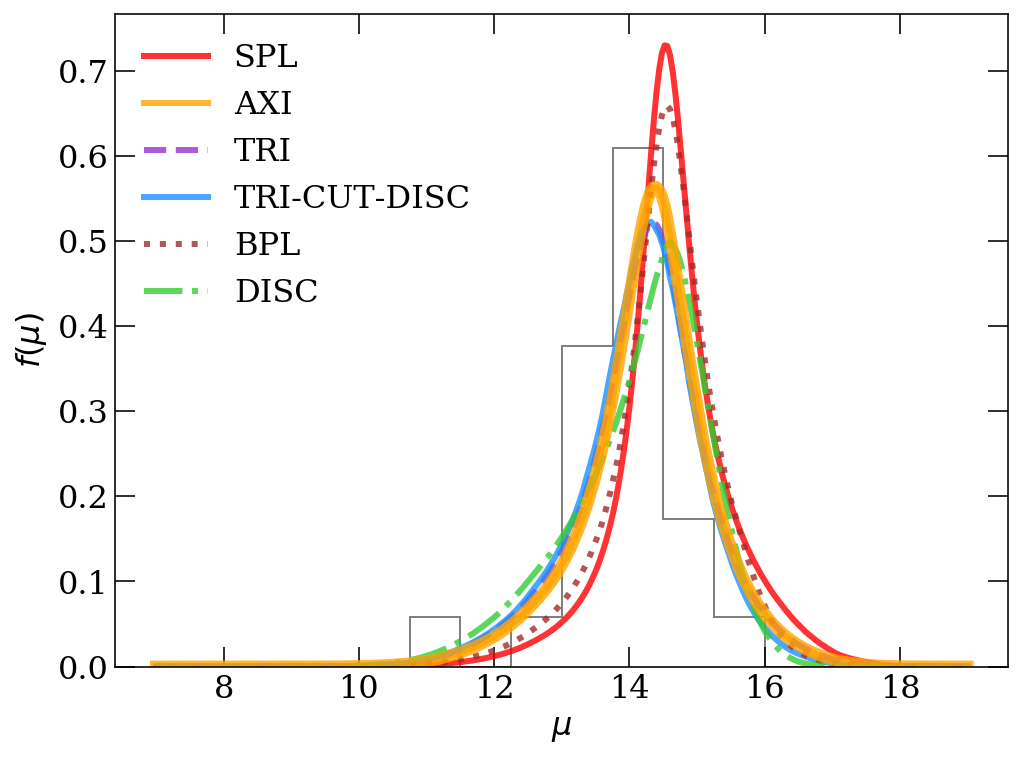

In [107]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params))*effsel[goodindx]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

# cut off
nrichpd9 = check_fit(nrichIndx, nrichsamples, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods, sample=True)
# spherical
nrichpd10 = check_fit(nrichIndx, nrichsamples2, outarea, densprofiles.spherical, distmods, sample=True)
# tri
nrichpd11 = check_fit(nrichIndx, nrichsamples3, outarea, densprofiles.triaxial_norot, distmods, sample=True)
# axisymmetric
nrichpd = check_fit(nrichIndx, nrichsamples5, outarea, densprofiles.axisymmetric, distmods, sample=True)
# Broken tri+rot+disc
nrichpd12 = check_fit(nrichIndx, nrichsamples4, outarea, densprofiles.broken_spl, distmods, sample=True)
# expdisc
nrichpd8 = check_fit(nrichIndx, nrichsamples6, outarea, densprofiles.justexpdisk, distmods, sample=True)



data_distmod= 5*np.log10(allstar_f[haloIndx]['weighted_dist'][nrichIndx])-5
# print(len(data_distmod))

plt.figure(figsize=(8,6))
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd10,50,axis=0),lw=3., color='red', label=r'SPL',alpha=0.8)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd,50,axis=0),lw=3., color='orange', label=r'AXI',alpha=0.8)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd11,50,axis=0),lw=3.,ls='dashed', color='darkorchid', label=r'TRI',alpha=0.8)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd9,50,axis=0),lw=3., color='dodgerblue', label=r'TRI-CUT-DISC',alpha=0.8)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd12,50,axis=0),lw=3., color='brown',ls='dotted', label=r'BPL',alpha=0.8)
plt.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=16, color='gray', histtype='step')
plt.plot(distmods,np.nanpercentile(nrichpd8,50,axis=0),lw=3., color='limegreen',ls='dashdot', label=r'DISC',alpha=0.8)
plt.plot(distmods,np.nanpercentile(nrichpd,50,axis=0),lw=6., color='orange',alpha=0.8)
plt.xlabel(r'$\mu$',fontsize=16)
plt.ylabel(r'$f(\mu)$',fontsize=16)
plt.tick_params(labelsize=16,direction='in',axis='both',right=True,top=True,length=10)
plt.legend(loc='upper left',fontsize=16,frameon=False)

# plt.savefig('../plots/n_rich_models_comparison_1panel.pdf', format='pdf', dpi=400, bbox_inches='tight')

